In [41]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.weightstats as smS
from dython.nominal import associations

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
#from sklearn.feature_selection import SelectFpr
#from sklearn.cluster import MeanShift
#from sklearn.feature_selection import f_regression
#from sklearn.feature_selection import SelectKBest
#from sklearn.preprocessing import RobustScaler

WMN = 'WMN'
UNKNOWN = 'UNK'
OTHER = 'Other'

AC, FB ='AC','FB'
PE, ALK = 'PE','ALK'
PVC = 'PVC'
CI, CLCI, DI, ELCI, CLDI, GI = 'CI','CLCI', 'DI', 'ELCI', 'CLDI','GI'
IRON='Iron'

MAX_PERCEN_TOSHOW = 2
SIG= 0.05

MAX_PRERanges='PreMax_Range'
LBL_MAX_PRE = 'Max pressure (m)'
LBL_PRE_FLU = 'Pressure fluctuation (m)'

INSERV_PROCESS = 'In Service'
MATERIALS_PREDOMI = [AC,PVC,IRON,PE]
MAT_EXT =  [AC,PVC,'Iron<=70','Iron>70',PE] 

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,120]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,120]']

PressFluc_bins = [0,5,10,15,100]
PFlucRange_labels = ['(0,5]','(5,10]','(10,15]','(15,100]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)
plt.rcParams['legend.facecolor'] = 'white'

In [42]:
def getAssetsRecords():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()

    WaterMain = AllAssetsCom[AllAssetsCom['Asset Type Code'] == WMN].copy()

    print("There are ", WaterMain.shape[0], " water mains in the database (NOT GIS)")

    waterMains = WaterMain[~WaterMain.index.duplicated(keep='first')]

    print("There are ", WaterMain.shape[0], " water mains not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterMains.index.names = [COMPKEY]

    return waterMains


def getFailureRecords(fname,numFailureRecordsOri):
    #Reads the cvs file result from the query to the Watercare DB and store it in a dataframe
    failureRecords = pd.read_csv(fname, delimiter = ',', 
                                 usecols=[0,1,7,9,8,5],
                                 dtype = {WONO:'str', ACTCODE:'str',SERVNO:'str',SR_PROB:'str',
                                          ADDDTTM:'str', COMPKEY:'int64'},
                                 index_col=0,
                                 parse_dates=[ADDDTTM],
                                )[[SERVNO,ACTCODE,SR_PROB,ADDDTTM,COMPKEY]]
    numFailureRecordsOri= failureRecords.shape[0]
    print('Number of records from the DB query:' , numFailureRecordsOri)

    failureRecords= failureRecords[~failureRecords.index.duplicated()].copy()

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records duplicated WONO: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]

    #For this study if it is the same type of Repair activity on the same asset associated 
    #to the same service number and in the same date 
    #The duplicated values are due diferencees in the contractor reference numbers used to add parts of the costs.
    #therefore the duplicates are not necesary unless the cost is needed
    failureRecords.drop_duplicates(inplace=True)

    #check for duplicates using only the date (not datetime) in the extraMethods.py file!!

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    return failureRecords, numFailureRecordsOri

def getFilterCodesAndSR() :

	fileACTCODE = 'Data/01-ACTCODERepair.csv'
	fileSR_Prob = 'Data/02-SR_PROB_TO_FILTER.csv'

	#read the filter files
	ACTCODERepair = pd.read_csv(fileACTCODE)
	SR_ToFilter = pd.read_csv(fileSR_Prob)

	return ACTCODERepair, SR_ToFilter

def filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair, numFailureRecordsOri):
	#filters the service codes related to third parties---------------------------------------------------------------
    failureRecords= failureRecords[~failureRecords[SR_PROB].isin(SR_ToFilter['SR_PROB_TO_FILTER'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' 3P Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]


	#filters the activities with actcodes not related to repairs------------------------------------------------------
    failureRecords= failureRecords[failureRecords[ACTCODE].isin(ACTCODERepair[ACTCODE])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' Not repair Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    
    return failureRecords, numFailureRecordsOri

def getAddressFromFailureRecords(fname):

	addressRecords = pd.read_csv(fname, delimiter = ',', 
								usecols=[0,12,13,14,15,16,17],
								dtype = {WONO:'str', 'Street_Type':'str','Street_Name':'str',SUBURB:'str',
								'FLAT':'str','HOUSENO':'str','POSTCODE':'str'})

	addressRecords.drop_duplicates(inplace=True)
	addressRecords.set_index(WONO, inplace=True, drop=True)

	return addressRecords

def filterFailuresbyInconsistentAddress(failures, addressRecords, assetAddresses):

	#adds the compkeys to the addressess of the failure table 
    failAddr= failures.join(addressRecords)[[COMPKEY,'Street_Type','Street_Name',SUBURB]]
    failAddr=failAddr.astype({COMPKEY: 'int64'})

	#creates the table to compare addresses 
    addrComp= failAddr.join(assetAddresses, on=COMPKEY)

	#compare the suburbs and drop the values that dont match
    indexToFilter= addrComp[addrComp[SUBURB].str.upper()!=addrComp[SUBURB].str.upper()].index
    failures.drop(indexToFilter , inplace=True)
    
    return failures

def getFailuresWithPipes(mainFailures, WMNFromAssetRecordsIndex):

	fWPipes = 'Data/00-Water_Pipe.csv'

	wPipesGIS = pd.read_csv(fWPipes, delimiter = ',', 
		                                dtype = {COMPKEY:'int64',STATUS:'str',MATERIAL:'str',
		                                         NOM_DIA_MM:'str',INSTALLED:'str',
                                                 'Shape_Leng' : 'float64'},
		                                usecols=[2,8,9,11,12,18],
		                                parse_dates=[INSTALLED],
		                                index_col=[COMPKEY]
		                                )

	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " length ", "%.2f" % wPipesGIS['Shape_Leng'].sum())
	originalGIS = wPipesGIS.shape[0]
    
    #merge duplicates compkeys
	wPipesGIS = wPipesGIS.groupby(wPipesGIS.index).agg({'Shape_Leng':sum, STATUS: 'first', NOM_DIA_MM: 'first', MATERIAL : 'first', INSTALLED:'first'})
	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " total length ", "%.2f" % wPipesGIS['Shape_Leng'].sum(),". Removed COMPKEY duplicates: ", originalGIS - wPipesGIS.shape[0])
	originalGIS = wPipesGIS.shape[0]
	
	#Delete no main pipes by the all assets dataset
	wPipesGIS = wPipesGIS[wPipesGIS.index.isin(WMNFromAssetRecordsIndex)].copy()
	print("Records of main pipes (GIS) ",  wPipesGIS.shape[0], ". Removed pipes with all assets WMN: ", originalGIS - wPipesGIS.shape[0])
	
    
	#look for the pipes of the failures and create a table with number of failure per pipe
	mainF_GISPipes= mainFailures.join(wPipesGIS, on= COMPKEY).copy()
	failuresWithPipesMissingInGIS = mainF_GISPipes[pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	failuresWithPipesInGIS = mainF_GISPipes[~pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	print('Failures with pipes in the GIS ', failuresWithPipesInGIS.shape[0], '. Failures with pipes missing in GIS ', failuresWithPipesMissingInGIS.shape[0])


	return failuresWithPipesInGIS, wPipesGIS


def manage_GISPipes(mainFailures,WMNFromAssetRecordsIndex):

    failuresWithPipesInGIS, wPipesGIS = getFailuresWithPipes(mainFailures,WMNFromAssetRecordsIndex)

    countNumFPerPipe = failuresWithPipesInGIS.groupby([COMPKEY]).agg({SERVNO: 'count', ACTCODE : 'first'})
    countNumFPerPipe.rename(columns={SERVNO:'Num of failures'}, inplace= True)


    #asign the number of failures per pipe including 0 to all the main pipe table and change formats
    wPipesGIS[NOM_DIA_MM] = pd.to_numeric(wPipesGIS[NOM_DIA_MM],errors='coerce')
    wPipesGISNfailures = wPipesGIS.join(countNumFPerPipe[['Num of failures']])
    wPipesGISNfailures["Num of failures"].fillna(0, inplace=True)
    wPipesGISNfailures["Age Today"] = (pd.to_datetime('today').tz_localize('UTC')-pd.to_datetime(wPipesGISNfailures["INSTALLED"])).astype('<m8[Y]')
    
    #calculates the age of failure and removes incorrect values
    failuresWithPipesInGIS["Age at failure"] = (pd.to_datetime(failuresWithPipesInGIS["ADDDTTM"].dt.tz_localize(None)) 
    - pd.to_datetime(failuresWithPipesInGIS["INSTALLED"]).dt.tz_localize(None)).astype('<m8[Y]')
    
    failuresWithPipesInGIS= failuresWithPipesInGIS[failuresWithPipesInGIS["Age at failure"]>=0].copy()
    
    for df in [failuresWithPipesInGIS,wPipesGISNfailures]:
        
        df['Shape_Leng'] = df['Shape_Leng']/1000 #pass to km
        df[MATERIAL] = df[MATERIAL].replace(UNKNOWN, np.nan)
        df[NOM_DIA_MM].fillna(0, inplace=True)

        #Combine AC
        df[MATERIAL] = df[MATERIAL].replace(FB, AC)

        #Combine PE
        df[MATERIAL] = df[MATERIAL].replace(ALK, PE)

        #combine CI
        df[MATERIAL] = df[MATERIAL].replace(CLCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(DI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(ELCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CLDI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(GI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CI, IRON) 

    return wPipesGISNfailures, failuresWithPipesInGIS


# -------------------- CONST --------------------

In [43]:
def getMaterialConst():
    
    fmaterialsConst='Data/Const-Materials.csv'

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=[MATERIAL])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=[DIAMETER])
    
    return diameterConst

def getAgeConst():
    
    fageConst='Data/Const-Ages.csv'

    ageConst = pd.read_csv(fageConst, delimiter = ',', index_col=['Age'])
    
    return ageConst

In [44]:
def getBase():
    
    fname = 'Data/03-WorkOrders.csv'
    numFailureRecordsOri = 0

    failureRecords , numFailureRecordsOri = getFailureRecords(fname,numFailureRecordsOri)
    ACTCODERepair, SR_ToFilter = getFilterCodesAndSR()

    failureRecords , numFailureRecordsOri = filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

    #divide between MAIN and SERViCE LINES------------------------------------------------
    mainFailures = failureRecords[(failureRecords[ACTCODE]=='WMNRM') | (failureRecords[ACTCODE]=='WMNRPL')].copy()

    numFailRecordsOriM = mainFailures.shape[0]

    print('Number of failures in Mains :', numFailRecordsOriM)

    addressFromFailureRecords = getAddressFromFailureRecords(fname)
    WMNFromAssetRecords = getAssetsRecords()

    mainFailures = filterFailuresbyInconsistentAddress(mainFailures, addressFromFailureRecords, WMNFromAssetRecords)
    print('Number of failures in Mains :', mainFailures.shape[0], ' Different address Deleted records: ', numFailRecordsOriM - mainFailures.shape[0])

    numFailRecordsOriM=mainFailures.shape[0]

    #returns the shape_length in km
    wPipesGISNfailures, failuresWithPipesInGIS = manage_GISPipes(mainFailures,WMNFromAssetRecords.index.tolist())

    
    #remove non predominan materials  and sort them 
    predoMaterials = wPipesGISNfailures[wPipesGISNfailures[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    predoMaterials.MATERIAL = pd.Categorical(predoMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    predoMaterials=predoMaterials.sort_values(MATERIAL).copy()

    failuresPMaterials= failuresWithPipesInGIS[failuresWithPipesInGIS[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    failuresPMaterials.MATERIAL = pd.Categorical(failuresPMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    failuresPMaterials=failuresPMaterials.sort_values(MATERIAL).copy()
    
    return predoMaterials, failuresPMaterials, wPipesGISNfailures


predoMaterials, failuresPMaterials, mainsGIS = getBase()
consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


# --------------------INTRINSIC CHARACTERISTICS ANALYSIS--------------------

In [45]:
def putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    df[colRanges]= pd.cut(df[col], bins=bins, labels=labels)
    #remove invalid values (nulls)----------------------------------
    dfOK= df[~pd.isna(df[colRanges])].copy()
    
    if getValidationVals is not None:
        const= getValidationVals()
        for i in const.index:
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]<const.loc[i, startCol])].index)
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]>const.loc[i,finishCol])].index)
    
    print("(Main in service) Pipe length with valid ",col+" ","%.2f" % dfOK['Shape_Leng'].sum()," from original ", "%.2f" % df['Shape_Leng'].sum())
    
    return dfOK


def getValidationYears():
    
    consYears = getMaterialConst()[['YearIni','YearFinal']]
    consYears = consYears[consYears.index.isin(MATERIALS_PREDOMI)]
    consYears['StartAge'] = 2021-consYears['YearIni'] 
    consYears['EndAge'] = 2021-consYears['YearFinal']
    consYears['EndAge'].replace(0, np.nan, inplace=True)
    consYears.index = pd.Categorical(consYears.index,categories= MATERIALS_PREDOMI)
    consYears=consYears.sort_index()
    
    return consYears


# From soil analysis -------------------------------------------------------------------

In [46]:
def joinWithGeoUnits(df):
    
    #Geounits 
    fGeoUnits = 'Data/Geounits/Geounits.csv'
    geoUnits = pd.read_csv(fGeoUnits, delimiter = ',', usecols=['main_rock'])
    
    #Water pipes FID
    fWaterPipesGISIDs = 'Data/Geounits/Water_pipes.csv'
    waterPipesGISIDs = pd.read_csv(fWaterPipesGISIDs, delimiter = ',', dtype = {COMPKEY:'int64'}, 
                                   usecols=[COMPKEY])
    print("Number of water pipe records ", waterPipesGISIDs.shape[0])

    #Intersections using FIDs
    fGeoUnitsIPipes = 'Data/Geounits/IntersectGeounitsVsWaterP.csv'
    geoUnitsIPipes = pd.read_csv(fGeoUnitsIPipes, delimiter = ',', dtype = {'FID_Water_':'int64'},
                                        usecols=[1,2,3],index_col=['FID_Water_'])
    print("Number of intersections " , geoUnitsIPipes.shape[0] , " so 1.7% extra")
    
    #joins the geounits interception to the id compkey table obtaining (COMPKEY,FID_NZL_GN) then eliminate the 
    pipesCKGeoUnitsID = waterPipesGISIDs.join(geoUnitsIPipes)
    
    #join the atributes of the geo units
    pipesCKGeoUnits = pipesCKGeoUnitsID.join(geoUnits, on='FID_250KGe').copy()
    assert pipesCKGeoUnitsID.shape[0] == pipesCKGeoUnits.shape[0] #check that the join was done correctly
    pipesCKGeoUnits = pipesCKGeoUnits.replace(" ", np.nan).copy()
    
    
    pipesGeounits= pipesCKGeoUnits.sort_values('Shape_Leng',ascending=False).drop_duplicates([COMPKEY],keep='first').set_index(COMPKEY)
    
    #//------------------------------------
    
    sizeO = df.shape[0]
    dfNSoil = df.join(pipesGeounits[['main_rock']].copy())
    
    assert sizeO == dfNSoil.shape[0] #check that the join was done correctly
    assert sizeO == len(dfNSoil.index.unique()) #there are not repeated COMPKEYS
    
    return dfNSoil


# From climate analysis ---------------------------------------------------------------

In [47]:
def getClimateData():

    fclimate='Data/Climate/00-ClimateInfoFinal.csv'

    climate = pd.read_csv(fclimate, delimiter = ',')
    
    climate= climate.replace('-', np.nan).copy()
    climate.loc[:,"Jan":"Dec"]= climate.loc[:,"Jan":"Dec"].astype(float,errors = 'raise').copy()

    climateTemp = climate[climate['Stats_Code']==2].copy()
    climateRainFall= climate[climate['Stats_Code']==0].copy()
    climateDefic= climate[climate['Stats_Code']==66].copy()
    
    return climateTemp,climateRainFall,climateDefic


def getPipesVsStations(df):
    
    fcliStaVsPipes='Data/Climate/05-WaterPipes_NearTablesClimate.txt'
    cliStaVsPipes = pd.read_csv(fcliStaVsPipes, delimiter = ',',usecols=[3,22,23,24,25],index_col=[COMPKEY])
    #remove duplicate compkeys 
    cliStaVsPipes= cliStaVsPipes.groupby(cliStaVsPipes.index).agg({'Rain_Dist': 'first', 'Rain_ID': 'first',
                                                   'NEAR_FID': 'first', 'NEAR_DIST': 'first'}).copy()

    fcliStaTemp='Data/Climate/04-StationsTemperature.txt'
    cliStaTemp = pd.read_csv(fcliStaTemp, delimiter = ',',usecols=[0,2,3,12],dtype = {'Agent_Numb':'Int64'},
                             index_col=['FID'])[['Agent_Numb']]
    cliStaTemp.rename(columns={'Agent_Numb':'Station Temperature'},inplace=True)
    
    fcliStaRain='Data/Climate/03-StationsRain.txt'
    cliStaRain = pd.read_csv(fcliStaRain, delimiter = ',',usecols=[0,2,3,12],dtype = {'Agent_Numb':'Int64'},
                             index_col=['FID'])[['Agent_Numb']]
    cliStaRain.rename(columns={'Agent_Numb':'Station Rain'},inplace=True)
    
    pipesVsStations = df.join(cliStaVsPipes)
    
    pipesVsStations = pipesVsStations.join(cliStaTemp,on='NEAR_FID')
    pipesVsStations = pipesVsStations.join(cliStaRain,on='Rain_ID')
     
    assert pipesVsStations.shape[0] == df.shape[0]
    
    return pipesVsStations


# Start from Pressure analysis --------------------------------------------------------

In [48]:
def getFailuresWithPressures(df):

	# Join by vicinity of the shape file "Water_Pipe" from Nish with the file of preassures from Mike
    fGISPipesPressure = 'Data/09-JoinWater_PipeVsPressure.csv'

    GISpipesVsPressures = pd.read_csv(fGISPipesPressure, delimiter = ',', 
	                            dtype = {COMPKEY:'int64', 'MOD_MAXPRE':'float64','MOD_MINPRE':'float64','Press_fluc':'float64',
                                        'Distance': 'float64'},
								usecols=[3,25,26,38,39,35],
	                            index_col=[COMPKEY])

    GISpipesVsPressures = GISpipesVsPressures.groupby(GISpipesVsPressures.index).agg({'MOD_MAXPRE': 'mean', 'MOD_MINPRE': 'mean',
                                                                                      'Press_fluc': 'mean', 'Distance': 'mean',
                                                                                     'MODEL_NAME': 'first'})

    wPipesGISNfailuresPressure = df.join(GISpipesVsPressures)
    print("Total Length of pipes with pressure (GIS)", "%.2f" % wPipesGISNfailuresPressure['Shape_Leng'].sum(), " in ",  wPipesGISNfailuresPressure.shape[0], "records")
    assert df.shape[0] == wPipesGISNfailuresPressure.shape[0]
    
    #remove pipes without near nodes
    dfNPressures= wPipesGISNfailuresPressure[wPipesGISNfailuresPressure['Distance']<1].copy()
    print("Total Length of pipes with VALID distance to pressure (GIS)", "%.2f" % dfNPressures['Shape_Leng'].sum(), " in ",  dfNPressures.shape[0], "records")

    
    #modify the names so they match with waterModelExtent 
    dfNPressures['MODEL_NAME']= dfNPressures['MODEL_NAME'].replace('_',' ', regex=True).str.title()
    dfNPressures['MODEL_NAME']=dfNPressures['MODEL_NAME'].replace({'Greenhithe Kyle':'Greenhithe & Kyle',
                                                    'Snells Algies' :'Snells & Algies','Gptk':'GPTK','Acg':'ACG',
                                                    'Okhd':'OKHD', 'Takg':'TAKG','Cbd':'CBD'})
    
    return dfNPressures

# Start Coordinates analysis ----------------------------------------------------

In [49]:
def getCoordinates(df):

    # Join by vicinity of the shape file "Water_Pipe" from Nish with the file of preassures from Mike
    fGISPipesCoord = 'Data/Coordinates/CoordinatesMiddlePointAll.txt'

    GISPipesCoord = pd.read_csv(fGISPipesCoord, delimiter = ',',
                               dtype = {COMPKEY:'int64', 'LAT':'float64','LONG':'float64'},
                                usecols=[3,24,25],
                                index_col=[COMPKEY])

    GISPipesCoord = GISPipesCoord.groupby(GISPipesCoord.index).agg({'LAT': 'first', 'LONG': 'first'})

    dfNCoordinates = df.join(GISPipesCoord)
    print("Total Length of pipes with coordinates (GIS)", "%.2f" % dfNCoordinates['Shape_Leng'].sum(), " in ",  dfNCoordinates.shape[0], "records")
    assert df.shape[0] == dfNCoordinates.shape[0]
    
    print("MaxLat:",dfNCoordinates['LAT'].max(),"MinLat:",dfNCoordinates['LAT'].min())
    print("MaxLong:",dfNCoordinates['LONG'].max(),"MinLong:",dfNCoordinates['LONG'].min())
     
    return dfNCoordinates

def joinWithSuburbs(df, address):
    
    dfWithAddress = df.join(address[[SUBURB]], on=COMPKEY)
    
    assert dfWithAddress.shape[0] == df.shape[0] #check that the join was done correctly
    
    
    return dfWithAddress
      

# From all matrix analysis ----------------------------------------------------

In [50]:
def validateIntrinsicValues(df,dfFailures):
    
    print("Before intrinsic values cleaning ", df.shape[0])
    
    df[NOM_DIA_MM]= df[NOM_DIA_MM].where(df[NOM_DIA_MM]>Diam_bins[0], np.nan)
    df[NOM_DIA_MM]= df[NOM_DIA_MM].where(df[NOM_DIA_MM]<=Diam_bins[len(Diam_bins)-1], np.nan)
    
    #reset the number of failures without the last year
    dfFailures['year']= dfFailures[ADDDTTM].dt.year
    failsB2019= dfFailures[dfFailures['year']<2019].groupby([COMPKEY]).agg({SERVNO: 'count'})
    df.drop(columns=['Num of failures'],inplace=True)
    df=df.join(failsB2019).rename(columns={"SERVNO": "NumFails"})
    df["NumFails"].fillna(0, inplace=True)
    
    df['Failures/Km/year']= (df['NumFails']/df['Shape_Leng']/6)
    
    df= df.drop(columns=[STATUS,INSTALLED,"NumFails"])
    
    const= getValidationYears()
    
    for i in const.index:
        
        ini=const.loc[i, "StartAge"]
        fin=const.loc[i, "EndAge"]
        
        condI= ~((df.MATERIAL == i) & (df['Age Today']>ini))
        condF= ~((df.MATERIAL == i) & (df['Age Today']<fin))
        df['Age Today'] = df['Age Today'].where(condI, np.nan)
        df['Age Today'] = df['Age Today'].where(condF, np.nan)
        
    df.dropna(inplace=True)
    
    df= df[['Failures/Km/year','Shape_Leng',NOM_DIA_MM,'Age Today',MATERIAL]]
        
    print("After intrinsic values cleaning ", df.shape[0] )
    
    return df


#Gets a table of records failures columns values of the pipe and climate of the failure month
def joinWithClimate(dfPipes):
    
    climateVals= getClimateData()
    
    #Get the station of each pipe
    dfPipesS=getPipesVsStations(dfPipes).copy()
    dfPipesS.drop(['Rain_Dist','Rain_ID','NEAR_FID','NEAR_DIST'], axis=1, inplace=True)
    assert dfPipesS.shape[0] == dfPipes.shape[0]
    
    for climate, sta,v in zip(climateVals,['Station Temperature','Station Rain','Station Rain'],
                             ["Temp M(max-min)","Rain M(max-min)","SMD M(max-min)"]):
       
        cli=climate.rename(columns={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7, 'Aug':8,
                                'Sep':9,'Oct':10,'Nov':11,'Dec':12, 'Station': sta,'Year ':"Year"})

        cli=cli.drop(['Stats_Code','Annual'], axis=1).set_index([sta,'Year']).copy()
        
        cli[v]= cli.max(axis=1)-cli.min(axis=1)
        cli= cli.reset_index().groupby([sta]).agg({v:'mean'}).copy()
        
        #Join pipes with climate
        dfPipesS= dfPipesS.join(cli, on=sta).copy()
        assert dfPipes.shape[0] == dfPipesS.shape[0]
        
    dfPipesS.drop(['Station Temperature','Station Rain'], axis=1,inplace=True)
    
    dfPipesS.dropna(inplace=True)
    
    print("After cleaning Climate ", dfPipesS.shape[0])

    return dfPipesS

def joinWithPressure(dfMains):
    
    #join with pressure (remove pressures that dont have a point near)
    dfMP= getFailuresWithPressures(dfMains)
    
    #validate pressures
    dfMP['MOD_MAXPRE'] = dfMP['MOD_MAXPRE'].where(dfMP['MOD_MAXPRE']>PressMax_bins[0], np.nan)
    dfMP['MOD_MINPRE'] = dfMP['MOD_MINPRE'].where(dfMP['MOD_MINPRE']>PressMax_bins[0], np.nan)
    dfMP['MOD_MAXPRE'] = dfMP['MOD_MAXPRE'].where(dfMP['MOD_MAXPRE']<=PressMax_bins[len(PressMax_bins)-1], np.nan)
    dfMP['MOD_MINPRE'] = dfMP['MOD_MINPRE'].where(dfMP['MOD_MINPRE']<=PressMax_bins[len(PressMax_bins)-1], np.nan)
    
    dfMP.dropna(inplace=True)
    dfMP.drop(columns=['Distance','MODEL_NAME','MOD_MINPRE'], inplace=True)
    
    print("After cleaning pressures ", dfMP.shape[0])
    
    return dfMP


#modified!!
def joinWithLocation(df):
    
    #join with coordinates
    #dfM= getCoordinates(df)
    
    #dfM.dropna(inplace=True)
    #print("After cleaning coordinates ", dfM.shape[0])
    
    #join with suburb
    WMNFromAssetRecords = getAssetsRecords()
    dfM= joinWithSuburbs(df, WMNFromAssetRecords)
    
    dfM.dropna(inplace=True)
    print("After cleaning suburbs ", dfM.shape[0])
    
    return dfM

def joinWithMainRock(df):
    
    dfM= joinWithGeoUnits(df)
    
    dfM.dropna(inplace=True)
    print("After cleaning geounits ", dfM.shape[0])
    
    return dfM
    


In [51]:
def joinWithValues(dfMains,dfFailures):
    
    dfMains= validateIntrinsicValues(dfMains,dfFailures) #diameter , current age and material and failure rate
     
    #dfMains= joinWithClimate(dfMains) #rain, temp and smd
     
    dfMains= joinWithPressure(dfMains) #max and fluctuation
    
    #dfMains=joinWithLocation(dfMains) #coordinates and suburb
    
    #dfMains= joinWithMainRock(dfMains) #main rock
    
    dfMains=dfMains.rename(columns={NOM_DIA_MM:DIAMETER,'MOD_MAXPRE':'Max Pressure',
                                    'MOD_MINPRE':'Min Pressure','Press_fluc':'Pressure Fluc',
                                    'main_rock':'Soil main rock','Age Today': 'Current age'})
    
    dfs = {}
    for m,outlinLim in zip(MATERIALS_PREDOMI,[350,400,0,500]):
        
        df= dfMains[dfMains[MATERIAL]==m].copy()
        df.drop(columns=[MATERIAL],inplace=True)
        print(m," (before)", df.shape[0])
         #ACA
        if m == "Iron":
            dfWithoutOut= df[(df['Current age']<=70)& (df['Failures/Km/year']<60)].copy()
            print(m," ", dfWithoutOut.shape[0])
            dfs[m+"<=70"]= dfWithoutOut.copy()
            #ax=sns.boxplot(x=a['Failures/Km/year'])
            dfWithoutOut= df[(df['Current age']>70)& (df['Failures/Km/year']<25)].copy()
            print(m," ", dfWithoutOut.shape[0])
            dfs[m+">70"]= dfWithoutOut.copy()
        else:
            dfWithoutOut= df[df['Failures/Km/year']<outlinLim].copy()
            print(m," ", dfWithoutOut.shape[0])
            dfs[m]= dfWithoutOut.copy()
     
    return dfs, dfMains

def scalateVariables(dfs):
    
    dfsScaled = {}  
    scalers = []
    
    for m in MAT_EXT:
        
        df= dfs[m]
    
        dfDis= df.select_dtypes(exclude=['object',]).copy()
        dfCate= df.select_dtypes(include=['object']).copy()
    
        scaler = MaxAbsScaler().fit(dfDis)
        scalers.append(scaler)
        transformation = scaler.transform(dfDis)
            
        dfScaled = pd.DataFrame(data=transformation, columns=dfDis.columns.tolist(), index=dfDis.index.tolist())
    
        dfAll= dfCate.join(dfScaled).copy()
        
        dfsScaled[m]= dfAll
        
    
    return dfsScaled, scalers

def getDummies(df):
    
    dfWithDummies = pd.get_dummies(df)
    
    return dfWithDummies
    


In [52]:
dfFinales, dfMix=joinWithValues(mainsGIS.copy(),failuresPMaterials.copy())

dfScaleds,scalers= scalateVariables(dfFinales.copy()) 

Before intrinsic values cleaning  212535
After intrinsic values cleaning  201836
Total Length of pipes with pressure (GIS) 9164.76  in  201836 records
Total Length of pipes with VALID distance to pressure (GIS) 6883.28  in  140503 records
After cleaning pressures  138543
AC  (before) 42653
AC   42644
PVC  (before) 27483
PVC   27474
Iron  (before) 29818
Iron   15806
Iron   13946
PE  (before) 31499
PE   31493


In [40]:
mainsGIS.groupby([MATERIAL]).agg({'Shape_Leng': 'sum'}).copy()



,Shape_Leng
MATERIAL,
ABS,0.560154
AC,3148.700121
CLS,189.780150
CONC,16.753413
CU,6.580416
ELS,0.679704
GS,49.516362
Iron,1077.988998
PE,2609.329925


In [95]:
dfMixI= dfMix[dfMix[MATERIAL] == IRON]
cols=dfMixI[[DIAMETER,'Current age','Temp M(max-min)','Rain M(max-min)','SMD M(max-min)',
                  'Max Pressure','Min Pressure','Pressure Fluc']]

stats=smS.DescrStatsW(cols, weights=dfMixI.Shape_Leng)

KeyError: "['Min Pressure', 'SMD M(max-min)', 'Rain M(max-min)', 'Temp M(max-min)'] not in index"

In [44]:
stats.mean

array([130.69210892,  69.02348048,   8.09220361, 170.88968359,
       124.29545527,  69.90491036,  57.60540654,  12.29950335])

In [34]:
stats.std

array([63.02888935, 21.77392189,  1.51916824, 17.15277762,  7.28218075,
       18.97368346, 17.11668305,  7.93321454])

# Test de outliners ---------------------------------------------------------------------

with  2848  without  2826


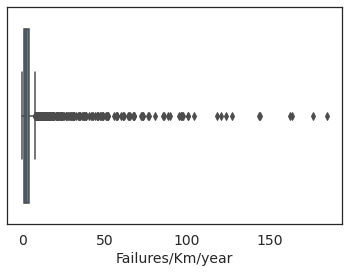

In [201]:
dfAC=dfFinal[dfFinal[MATERIAL]=='AC'][['Failures/Km/year','Shape_Leng']]

dfACWithoutOut = dfAC[dfAC['Failures/Km/year']<200].copy()

print("with ", dfAC.shape[0],' without ', dfACWithoutOut.shape[0])

ax=sns.boxplot(x=dfACWithoutOut['Failures/Km/year'])

with  1611  without  1591


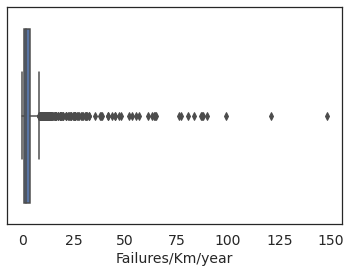

In [203]:
dfPVC=dfFinal[dfFinal[MATERIAL]=='PVC'][['Failures/Km/year','Shape_Leng']]
dfPVCWithoutOut = dfPVC[dfPVC['Failures/Km/year']<200].copy()

print("with ", dfPVC.shape[0],' without ', dfPVCWithoutOut.shape[0])

ax=sns.boxplot(x=dfPVCWithoutOut['Failures/Km/year'])

with  15835  without  15829


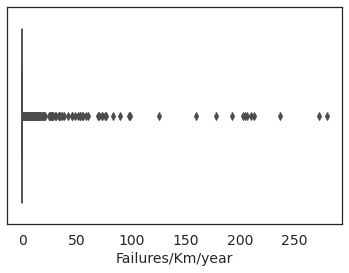

In [83]:
dfIR=dfMix[(dfMix[MATERIAL] == IRON)& (dfMix['Current age']<=70)][['Failures/Km/year','Shape_Leng']].copy()
dfIrWiOut = dfIR[dfIR['Failures/Km/year']<300].copy()

print("with ", dfIR.shape[0],' without ', dfIrWiOut.shape[0])

ax=sns.boxplot(x=dfIrWiOut['Failures/Km/year'])

with  13983  without  13945


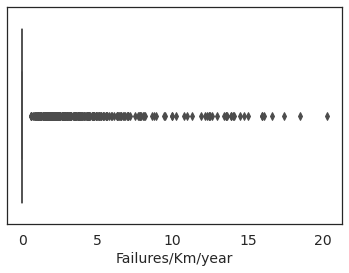

In [79]:
dfIR=dfMix[(dfMix[MATERIAL] == IRON)& (dfMix['Current age']>70)][['Failures/Km/year','Shape_Leng']].copy()
dfIrWiOut = dfIR[dfIR['Failures/Km/year']<23].copy()

print("with ", dfIR.shape[0],' without ', dfIrWiOut.shape[0])

ax=sns.boxplot(x=dfIrWiOut['Failures/Km/year'])

with  948  without  926


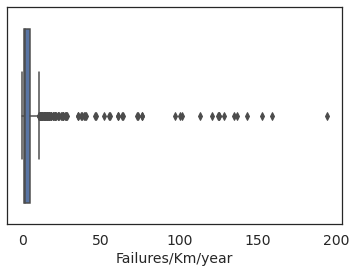

In [205]:
dfPE=dfFinal[dfFinal[MATERIAL]=='PE'][['Failures/Km/year','Shape_Leng']].copy()
dfPEWiOut = dfPE[dfPE['Failures/Km/year']<200].copy()

print("with ", dfPE.shape[0],' without ', dfPEWiOut.shape[0])

ax=sns.boxplot(x=dfPEWiOut['Failures/Km/year'])

In [202]:
for m in MATERIALS_PREDOMI:
    
    dfMainsMFail = dfFinal[dfFinal[MATERIAL]==m][['Failures/Km/year']].copy()

    outlinLim = np.quantile(dfMainsMFail,0.95)
    
    print(m, ": ",outlinLim)
    
dfMainsMFail = dfFinal[['Failures/Km/year']].copy()

outlinLim = np.quantile(dfMainsMFail,0.95)
    
print("All: ",outlinLim)

AC :  64.2147824678423
PVC :  64.55658923522324
Iron :  285.8857512470256
PE :  237.7450620514798
All:  118.68928577024563


In [102]:
dfFinal.describe().T

,count,mean,std,min,25%,50%,75%,max
Failures/Km/year,132088.0,0.316335,3.660794,0.000000,0.000000,0.000000,0.000000,193.935440
Shape_Leng,132088.0,0.049887,0.069988,0.000003,0.003266,0.020672,0.072135,2.195685
Diameter,132088.0,113.748940,52.415596,30.000000,100.000000,100.000000,150.000000,685.000000
Current age,132088.0,44.732920,23.959207,3.000000,23.000000,45.000000,60.000000,122.000000
Temp M(max-min),132088.0,8.867933,1.831350,4.300000,9.125000,9.250000,10.033333,10.683333
Rain M(max-min),132088.0,171.796505,16.381680,137.900000,168.550000,168.550000,183.600000,199.300000
SMD M(max-min),132088.0,122.515234,6.790107,102.460000,119.233333,122.925000,126.680000,134.100000
Max Pressure,132088.0,67.737312,18.892312,20.511391,53.405185,66.920490,81.783897,119.985573
Pressure Fluc,132088.0,10.522425,7.991197,0.000000,4.817687,9.139400,13.871900,76.981100


# Create Matrix ------------------------------------------------------------------

In [53]:
def createCrossVaGraph(df,material=None):
    
    size= (20,10) if material is None else (12,7)
    
    fig1, ax  = plt.subplots(figsize=size)

    result = associations(dataset=df,ax=ax)
    
    if material is None:
    
        fig1.savefig('Maps_Graph/CorrelationAnalysis/'+ 'CrossCorrelationMatrix' +'.png', dpi=200, bbox_inches='tight')
        
    else:
        
        fig1.savefig('Maps_Graph/CorrelationAnalysis/'+ 'CrossCorrelationMatrix'+material +'.png', dpi=200, bbox_inches='tight')
        
    
    return result['corr']

def modDFToGetSmallerLengths(df):
    
    MAXLENG= 0.001

    #copy the rows that are larger
    auxLarger=df[df['Shape_Leng']>MAXLENG].copy() 

    while not (auxLarger.shape[0]==0):

        #changes the larger in the original df with the new length
        df['Shape_Leng']= df['Shape_Leng'].where(df['Shape_Leng'] < MAXLENG, df['Shape_Leng']/2) 
        #changes the extra df
        auxLarger['Shape_Leng']= auxLarger['Shape_Leng'].where(auxLarger['Shape_Leng'] < MAXLENG, auxLarger['Shape_Leng']/2) 
        #Join both df
        df=pd.concat([df, auxLarger])
        #creates the extra rows
        auxLarger=df[df['Shape_Leng']>MAXLENG].copy()
        
    return df


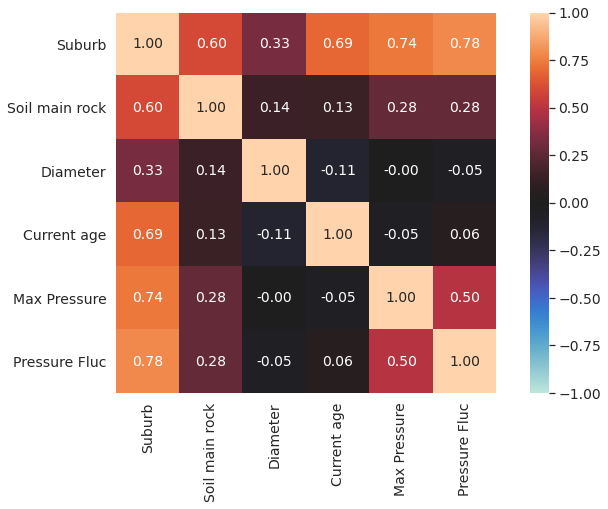

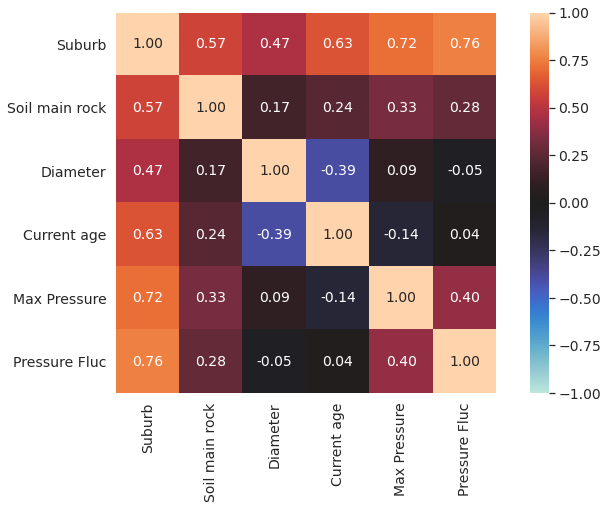

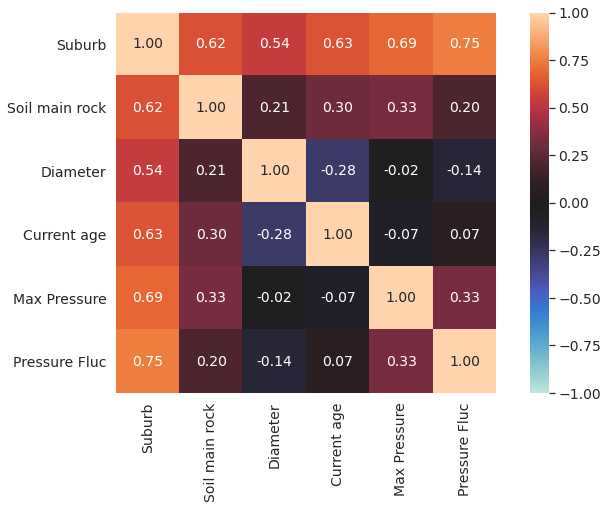

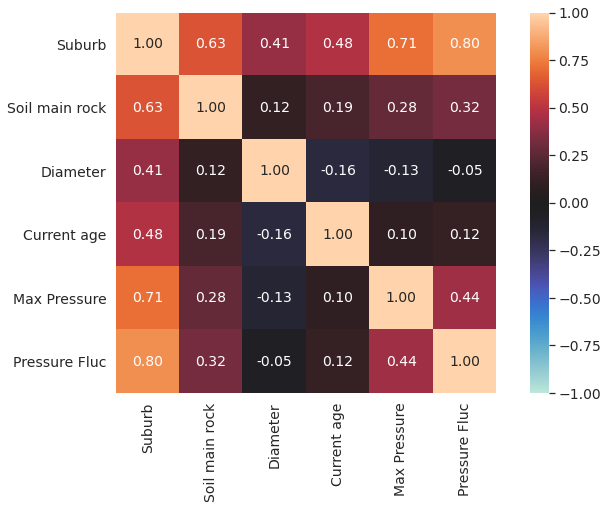

In [55]:
def getCrossCorrelationByMaterial(dfScaleds):
    
    for m in MATERIALS_PREDOMI:
        
        dfS= dfScaleds[m].copy()
        
        dfScaledExp= modDFToGetSmallerLengths(dfS.copy()) 
        
        createCrossVaGraph(dfScaledExp.drop(columns=['Shape_Leng','Failures/Km/year']),m)

        
getCrossCorrelationByMaterial(dfScaleds)

# Finish matrix part -----------------------------------------------------------------

# Start Regression by material -----------------------------------------

In [74]:
# the dataset should be scalated already
def prepareForMLReg(dfs):
    
    dfDicc={}
 
    for m in MAT_EXT:
        
        df=dfs[m]
        
        # remove colinearities based on the cross correlation matrix
        #df= df.drop(columns=[SUBURB]) #'Rain M(max-min)','Temp M(max-min)','SMD M(max-min)'
        
        #gets columns to remove
        #dfGroup= df.groupby(['Soil main rock']).agg({'Shape_Leng':sum}).copy()
        #dfGroup['%']= dfGroup['Shape_Leng']*100/ dfGroup['Shape_Leng'].sum()
        #colsToRemove = dfGroup[dfGroup['%']< MAX_PERCEN_TOSHOW].index.tolist()
        
        #print(m,": ",colsToRemove)
        #colsToRemove= ['Soil main rock_'+ c for c in colsToRemove]
        
        #create dummies
        dfm= getDummies(df.copy())
        
        #drops soils without importan percentage per material in all materials
        #dfm= dfm.drop(columns=colsToRemove,errors='ignore')    
  
        dfDicc[m] = dfm
        
    
    return dfDicc


In [68]:
def getGraphCoef(model,m,label):

    coeff = model.params
    coeff = coeff.iloc[(coeff.abs()*-1.0).argsort()]
    
    fig1, ax  = plt.subplots(figsize=(12,6))
    ax = sns.barplot(x=coeff.values, y=coeff.index, orient='h',ax=ax, palette='crest')
    
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.grid(axis='x', which='both')
    ax.set_title(m)
    ax.set_xlabel("Coefficient",fontsize=14)
    
    fig1.savefig('Maps_Graph/CorrelationAnalysis/'+'results'+ m +label+'.png', dpi=200, bbox_inches='tight')
                       

In [69]:
def getModelIterGraph(df,r,m,label):
    
    fig1, ax  = plt.subplots(figsize=(12,6))
    ax = df.AIC.plot(ax= ax,alpha=0.7,marker='o',ms=12,linewidth=5,rot=r)
    han,lab = ax.get_legend_handles_labels()
        
    ax2 = df.rAjusted.plot(ax= ax,alpha=0.7,marker='o',ms=12,linewidth=5,rot=r,secondary_y=True)
    h,l = ax2.get_legend_handles_labels()
    han.append(h[0]),lab.append(l[0] + ' (Right)')
        
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("AIC")
    ax2.spines['top'].set_visible(False)
    ax2.set_ylabel("R2 (Ajusted)")
    ax.set_title(m)
        
    ax.legend(han,lab,ncol=2, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(0.5, 1.13))
    
    fig1.savefig('Maps_Graph/CorrelationAnalysis/'+'itera'+m +label+'.png', dpi=200, bbox_inches='tight')
       


    

In [70]:
def FPRModel(Xx,y):
    
    model = SelectFpr(f_regression).fit(Xx,y.values.ravel()).get_support()
    print(model)
    try:
        bestF= Xx.columns[model][0]
        print("Best ", bestF)
    except:
        bestF= None
      
    return bestF

def RecFECV(Xx,y):
    
    sel = RFECV(LinearRegression()).fit(Xx, y).get_support()
    Xnew=Xx.loc[:,sel]
    
    return Xnew


def SFSModel(Xx,y):
    
    if Xx.shape[1] > 1:
    
        sfs = SFS(LinearRegression()).fit(Xx,y).get_support()
        bestF= Xx.columns[sfs][0]
        #print("Best ", bestF)
    else:
        bestF=Xx.columns.tolist()[0]
     
    return bestF
    

def getBestFeature(Xx,y):
    
    bestFModel= SelectKBest(LinearRegression(), k=1).fit(Xx, y.values.ravel()).get_support()
    bestF= Xx.columns[bestFModel][0]
    #print("Best ", bestF)
    
    return bestF
    

def runsModel(X,y,w,bestF,mate,graph=False,label=None):
    
    #print("Regression with ", X.columns.tolist())
    
    model = sm.WLS(y, X,weights=w).fit()
    insigni = any([pv > SIG for pv in model.pvalues[1:]])
    #print(model.pvalues)
    #print("Generated high p-values: ", insigni)
    
    if insigni:
        X.pop(bestF)
        #print("The parameter ", bestF, " was removed")

    if graph and insigni:
        model = sm.WLS(y, X,weights=w).fit()
        getGraphCoef(model,mate,label)
    elif graph:
        getGraphCoef(model,mate,label)
        
    return X, model.aic, model.rsquared_adj

def recursiveFoward(dfm,material):
    
    y= dfm[['Failures/Km/year']].copy()
    w= dfm[['Shape_Leng']].copy() 
    
    Xall= dfm.iloc[:, 2:]
    Xini = y[[]]
    Xini = sm.add_constant(Xini)
    Xini = Xini.join(Xall)
    
    #print(Xini.columns.tolist()[:3])
    
    X=RecFECV(Xini,y)
    
    modelTestP = sm.WLS(y, X,weights=w).fit()
    pvaluesTest= modelTestP.pvalues[1:]
    invalidPval= any([pv > SIG for pv in pvaluesTest])
        
    while invalidPval:
        #print("Invalid p values with RFCV ")
        maxV= pvaluesTest.idxmax()
        #print("Max:", maxV)
        X.pop(maxV)
        #print("Then X has now the features ",X.columns.tolist())
        modelTestP = sm.WLS(y, X,weights=w).fit()
        pvaluesTest= modelTestP.pvalues[1:]
        invalidPval= any([pv > SIG for pv in pvaluesTest])
            
    model = sm.WLS(y, X,weights=w).fit()
    
    getGraphCoef(model,material,"RFCV")
    print("RFCV ","AIC:",model.aic," CN:",model.condition_number," F:",model.fvalue, " pv:", model.f_pvalue)
    
    return model, X, w
    
    

def getMLRFowardsBest(dfm,material,bestMet):
    
    y= dfm[['Failures/Km/year']].copy()
    w= dfm[['Shape_Leng']].copy() 
    Xall= dfm.iloc[:, 2:]
    results = []
    
    #selects all and the best
    bestF= bestMet(Xall,y)
    
    X = Xall[[]]
    X = sm.add_constant(X)
    newV = Xall.pop(bestF) #removes the bestF from Xall
    X = X.join(newV)
    
    
    while Xall.shape[1]>0:
        
        model = sm.WLS(y, X,weights=w).fit()
        insigni = any([pv > SIG for pv in model.pvalues[1:]])
        
        if insigni:
            X.pop(bestF)
        
        #X,aic,r = runsModel(X,y,w,bestF,material,label="BestF")
        #results.append([bestF,aic,r])
        
        bestF= bestMet(Xall,y)
        
        if bestF is None:
            break
            
        newV= Xall.pop(bestF)
        X = X.join(newV)
        
    #X,aic,r = runsModel(X,y,w,bestF,material,True,label="BestF")
    #results.append([bestF,aic,r])
    #resultDf= pd.DataFrame(results, columns =["Variable added",'AIC','rAjusted'])
    #getModelIterGraph(resultDf,45,material,"BestF")
    
    #runs the last model again
    model = sm.WLS(y, X,weights=w).fit()
    getGraphCoef(model,"AC","SFS")
    
    print("Best ","AIC:",model.aic," CN:",model.condition_number," F:",model.fvalue, " pv:", model.f_pvalue)

In [71]:
def getMLRFowardsLowestP(dfm,material,P):
    
    y= dfm[['Failures/Km/year']].copy()
    w= dfm[['Shape_Leng']].copy() 
    Xall= dfm.iloc[:, 2:]
    results = []
    
    X = Xall.iloc[:,1:2]
    X = sm.add_constant(X)[['const']]
    
    while Xall.shape[1]>0:
        
        #For each variable looks the better fit
        Params=[]
        for v in Xall.columns.tolist():
            
            Xtest = X.join(Xall[[v]]).copy()
            mTest = sm.WLS(y, Xtest,weights=w).fit()
            
            para = mTest.f_pvalue if "PValue" else mTest.AIC
            resultP= [v,para]
            Params.append(resultP)
        
        #gets the best feature by min Tstatistic pvalue
        fDF= pd.DataFrame(Params, columns =['v','Param'])
        bestF= fDF.loc[fDF['Param'].idxmin()]['v']
        #print("Best:",bestF)
        
        #runs the model and check the p-values
        bestFdf= Xall.pop(bestF) #remove it from the dataset
        X = X.join(bestFdf).copy()
        modelTestP = sm.WLS(y, X,weights=w).fit()
        pvaluesTest= modelTestP.pvalues[1:]
        invalidPval= any([pv > SIG for pv in pvaluesTest])
        
        if invalidPval:
            X.pop(bestF)
            #print("Invalid pvalues with ", bestF)
    
    model = sm.WLS(y, X,weights=w).fit()
    getGraphCoef(model,material,"FowPval")
    print("Foward",P," AIC:",model.aic," CN:",model.condition_number," F:",model.fvalue, " pv:", model.f_pvalue)



In [72]:
def getMLRBackwardsIterMaterial(dfm,material):
    
    y= dfm[['Failures/Km/year']].copy()
    w= dfm[['Shape_Leng']].copy() 
    Xall= dfm.iloc[:, 2:]
    results = []
    
    Xall = sm.add_constant(Xall)
 
    
    while Xall.shape[1]>0:
         
        model = sm.WLS(y, Xall,weights=w).fit()
        
        var= Xall.columns.tolist()
        var.remove('const')
        pVal= [[v,model.pvalues[v]] for v in var]
        dfPvalues= pd.DataFrame(pVal, columns =['Variable','P-value'])
        
        try:
            noSig = dfPvalues[dfPvalues['P-value']> SIG].sort_values(by='P-value',ascending=False).copy().iloc[0,0]
        
            #runs the model and check the p-values
            worstFdf= Xall.pop(noSig) #remove it from the dataset
            #print("X has the features ",Xall.columns.tolist())
            
        except:
            #print("No invalid p-values ", all([pv <= 0.1 for pv in model.pvalues]))
            break
        
        results.append([noSig,model.aic,model.rsquared_adj])
        
        
    resultDf= pd.DataFrame(results, columns =['Variable removed','AIC','rAjusted'])
    
    getModelIterGraph(resultDf,0,material,"BackIter")
    getGraphCoef(model,material,"BackwIter")
    print("Back ","AIC:",model.aic," CN:",model.condition_number," F:",model.fvalue, " pv:", model.f_pvalue)
    

In [75]:
dtMaterialDicc= prepareForMLReg(dfScaleds.copy()) #ACA 3

dfAC=dtMaterialDicc['AC'].copy()
dfPVC=dtMaterialDicc['PVC'].copy()
dfIronLess= dtMaterialDicc['Iron<=70'].copy()
dfIronMore= dtMaterialDicc['Iron>70'].copy()
dfPE= dtMaterialDicc['PE'].copy()

RFCV  AIC: -306491.49605930335  CN: 5.192091308343964  F: 998.8801912651741  pv: 0.0
RFCV  AIC: -211751.37381215254  CN: 7.156372832319295  F: 387.45625682294906  pv: 1.6397414650763321e-246
RFCV  AIC: -61469.87748014652  CN: 11.129168689192571  F: 154.03006668940503  pv: 1.6865956827010804e-129
RFCV  AIC: -43304.854095234856  CN: 6.320206354825632  F: 134.56847868226296  pv: 6.046093578091686e-86
RFCV  AIC: -239878.28003618232  CN: 5.723665562519095  F: 180.8211270131158  pv: 2.98462429299426e-116


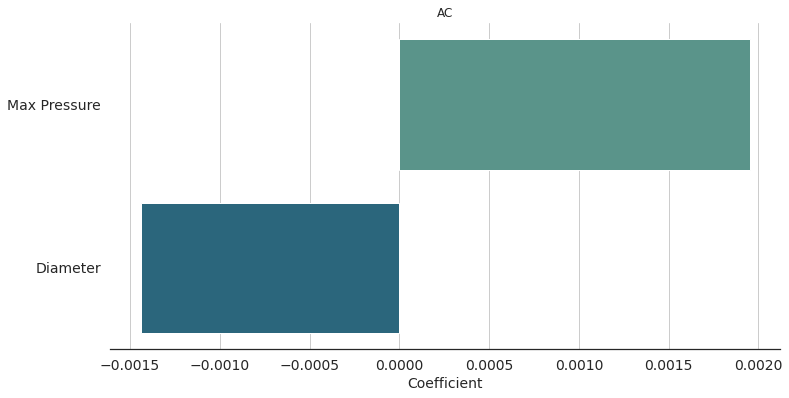

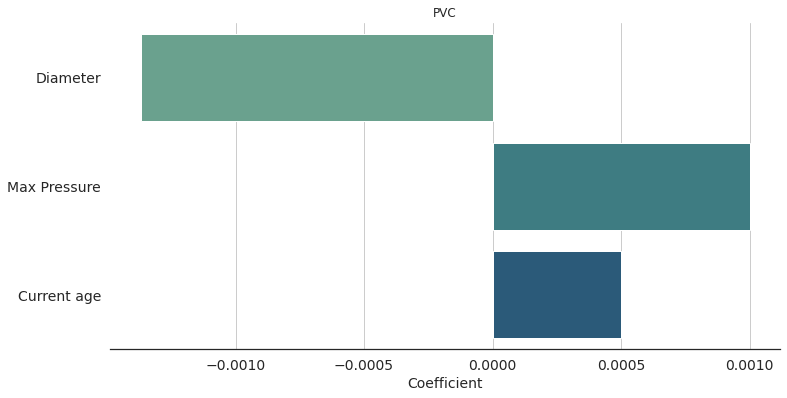

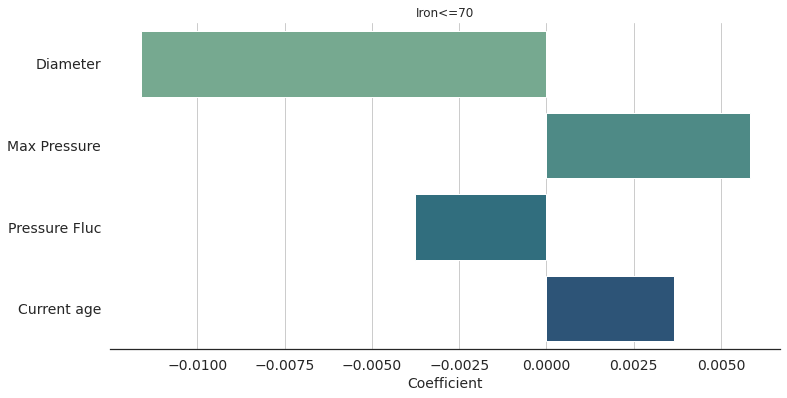

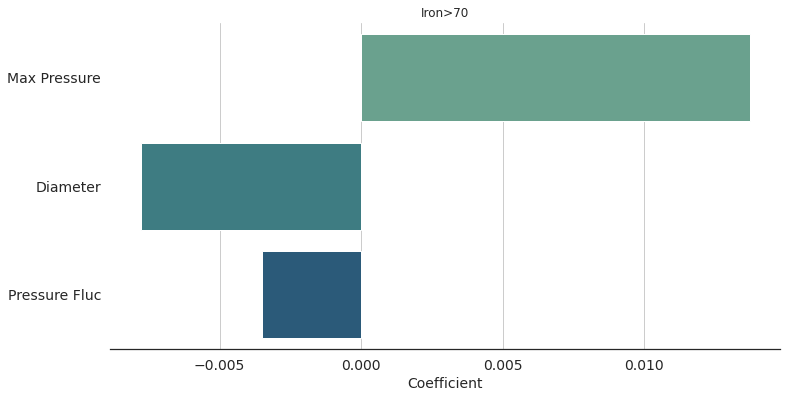

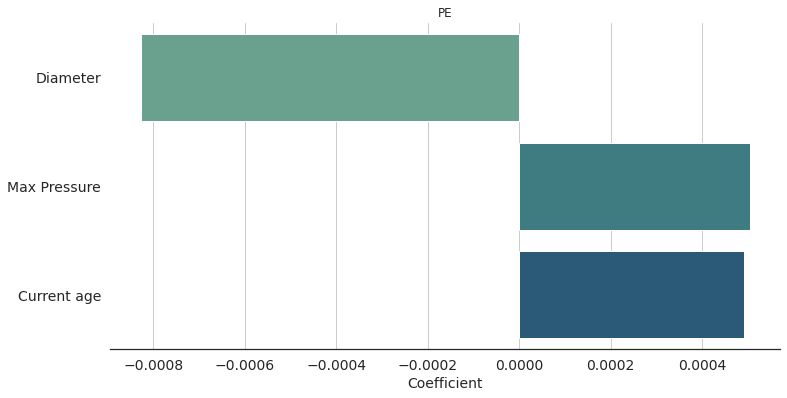

In [76]:
modelAC, XAC,wAC =recursiveFoward(dfAC.copy(),"AC")
modelPVC, XPVC,wPVC=recursiveFoward(dfPVC.copy(),"PVC")
modelIronLess, XIL,wIL=recursiveFoward(dfIronLess.copy(),"Iron<=70")
modelIronMore, XIMo,wIMo=recursiveFoward(dfIronMore.copy(),"Iron>70")
modelPE, XPE,wPE=recursiveFoward(dfPE.copy(),"PE")

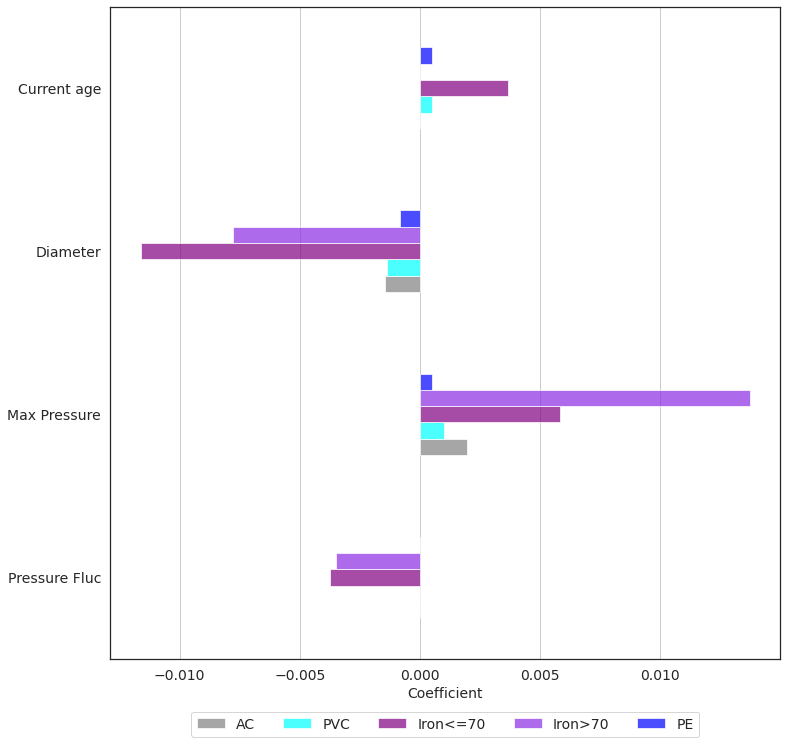

In [85]:
dsCoefficients = pd.DataFrame(data=modelAC.params).rename(columns={0: "AC"})

for mod,l in zip([modelPVC,modelIronLess,modelIronMore,modelPE],
              ['PVC','Iron<=70','Iron>70','PE']):
    
    dfN= pd.DataFrame(data=mod.params).rename(columns={0: l})
    dsCoefficients= dsCoefficients.join(dfN,how='outer')
    dsCoefficientsInv= dsCoefficients.reindex(index=dsCoefficients.index[::-1])

fig1, ax  = plt.subplots(figsize=(12,12))
      
dsCoefficientsInv.plot.barh(color=pal,ax=ax,alpha=0.7)
ax.set_xlabel("Coefficient",fontsize=14)
ax.grid(axis='x', which='both')
ax.legend(loc='upper center',bbox_to_anchor=(.5,-.07), ncol=5,  fontsize=14)

fig1.savefig('Maps_Graph/CorrelationAnalysis/'+'resultsTotal'+ '.png', dpi=200, bbox_inches='tight')
    

In [214]:
dsCoefficients


,PE,Iron>70,Iron<=70,PVC,AC
Current age,0.000466,NaN,0.003024,0.000496,NaN
Diameter,-0.000827,-0.009841,-0.012832,-0.001403,-0.001441
Max Pressure,0.000520,0.017363,0.004465,0.000969,0.001951
Pressure Fluc,NaN,-0.004294,NaN,NaN,NaN
Soil main rock_basalt,NaN,NaN,NaN,0.000168,NaN
Soil main rock_mud,NaN,NaN,0.001926,NaN,NaN
Soil main rock_sand,NaN,NaN,0.002504,NaN,NaN
Soil main rock_tuff,NaN,NaN,NaN,0.000148,NaN
Soil main rock_turbidite,NaN,NaN,0.001461,NaN,NaN


In [84]:
pal=[consCoM[m] for m in MATERIALS_PREDOMI]
pal.insert(3,'blueviolet')
pal

['grey', 'cyan', 'purple', 'blueviolet', 'blue']

In [22]:
def getListMostFailed(model,dfValues,km,mat):
    
    yPre= model.get_prediction().summary_frame()
    print("Target replaced KM", km)
    
    #mean predicted failure rate
    mostfailed= yPre['mean'].sort_values(ascending=False)
  
    #attach the atributes keeping the order
    mostFailedAttributes =dfValues.reindex(mostfailed.index)
     
    #get the number of pipes that doesnt sum more than the km given in the parameter
    mostFailedAtt= mostFailedAttributes[np.less_equal(mostFailedAttributes.Shape_Leng.cumsum().values, km)]
    
    print("Product replaced KM ", mostFailedAtt.Shape_Leng.sum())
    mostFailedAtt.to_csv('Output/Regressions/'+"highestFailuresReg"+mat+'.csv')
    

In [23]:
totalReplace = predoMaterials.Shape_Leng.sum()/100
matPropo= failuresPMaterials.groupby([MATERIAL]).agg({SERVNO: 'count'})
matPropo['%'] = matPropo[SERVNO]/ matPropo[SERVNO].sum()*100
matPropo['kmReplace'] = matPropo['%'] * totalReplace/100

In [25]:
matPropo

,SERVNO,%,kmReplace
MATERIAL,,,
AC,6001,47.725465,43.776781
PVC,3211,25.536822,23.423970
Iron,1236,9.829808,9.016514
PE,2126,16.907905,15.508988


In [33]:
#percentage of the Iron
fIron = failuresPMaterials[failuresPMaterials[MATERIAL]==IRON].copy()
fIronLess = fIron[fIron['Age at failure']<=70].shape[0]
fIronMore = fIron[fIron['Age at failure']>70].shape[0]
PerceIronLess = fIronLess/ matPropo[SERVNO].sum()*100
PerceIronMore = fIronMore/ matPropo[SERVNO].sum()*100
kmReplaceIronLess = PerceIronLess * totalReplace/100
kmReplaceIronMore = PerceIronMore * totalReplace/100
print("num failures less", fIronLess, " num failures more", fIronMore)
print("Replace ", kmReplaceIronLess,"representing ",PerceIronLess, " of iron with age <=70")
print("Replace ", kmReplaceIronMore,"representing ",PerceIronMore, " of iron with age >70")

num failures less 809  num failures more 427
Replace  5.901585749939592 representing  6.433911245427073  of iron with age <=70
Replace  3.1149284489792404 representing  3.3958962939398765  of iron with age >70


In [36]:
for m,modMat in zip(MAT_EXT,[modelAC,modelPVC,modelIronLess,modelIronMore,modelPE]):
    
    print(m)
    if (m == "Iron<=70"):
        repl = kmReplaceIronLess
    elif (m == "Iron>70"):
        repl = kmReplaceIronMore
    else:
        repl = matPropo.loc[m].kmReplace
        
    getListMostFailed(modMat,dfFinales[m].copy(),repl,m)

AC
Target replaced KM 43.77678131691901
Product replaced KM  43.74937168484703
PVC
Target replaced KM 23.423970139747873
Product replaced KM  23.420979437282647
Iron<=70
Target replaced KM 5.901585749939592
Product replaced KM  5.8560485878996325
Iron>70
Target replaced KM 3.1149284489792404
Product replaced KM  3.0980605407532744
PE
Target replaced KM 15.508988015292424
Product replaced KM  15.494371217090238


In [34]:
totalReplace

91.72625367087814

Foward PValue  AIC: -306573.8579853643  CN: 17.458106727667627  F: 77.91247689879117  pv: 5.815023610219053e-66
Foward AIC  AIC: -306573.8579853643  CN: 17.458106727667627  F: 77.91247689879117  pv: 5.815023610219053e-66
Best  AIC: -306544.79389030254  CN: 16.104371775934677  F: 93.4601113044804  pv: 2.763669166144238e-60
Back  AIC: -306573.8579853643  CN: 17.458106727667616  F: 77.91247689879117  pv: 5.815023610219053e-66
RFCV  AIC: -306397.5606371132  CN: 5.191929735102441  F: 998.8326347476703  pv: 0.0


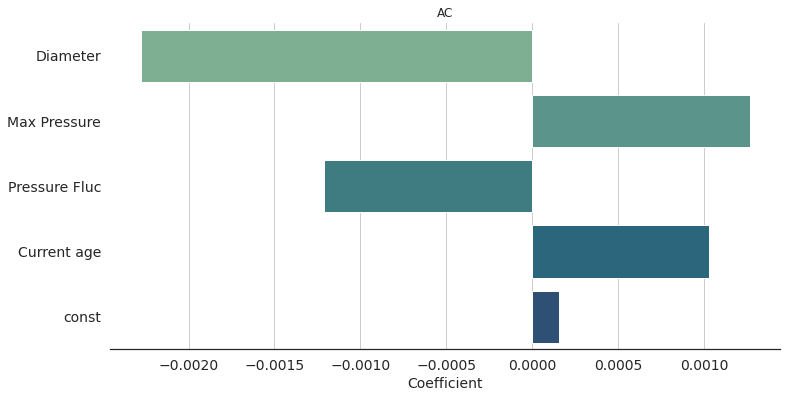

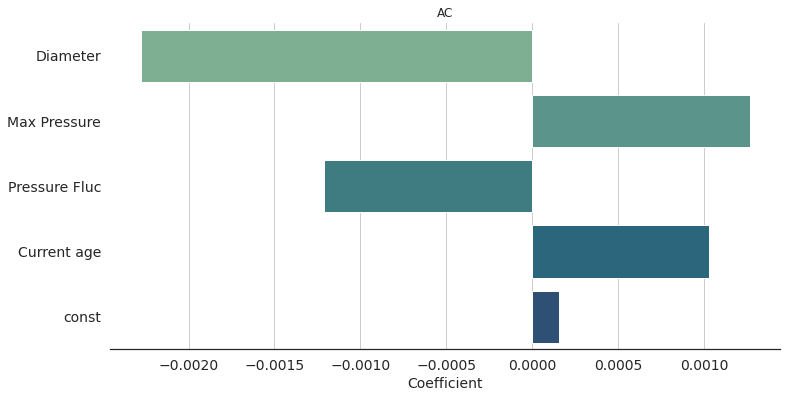

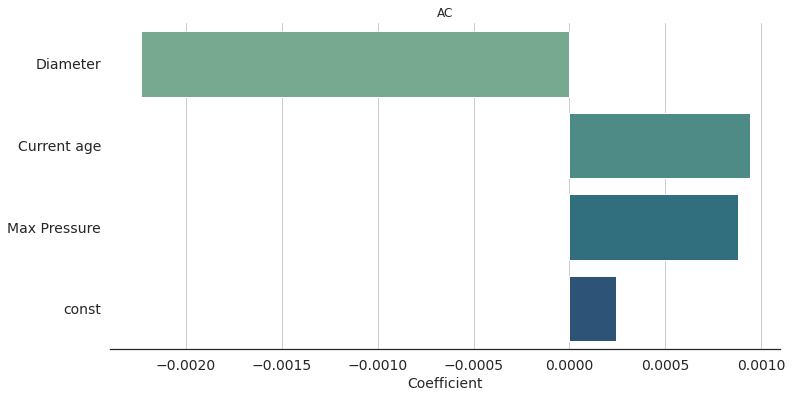

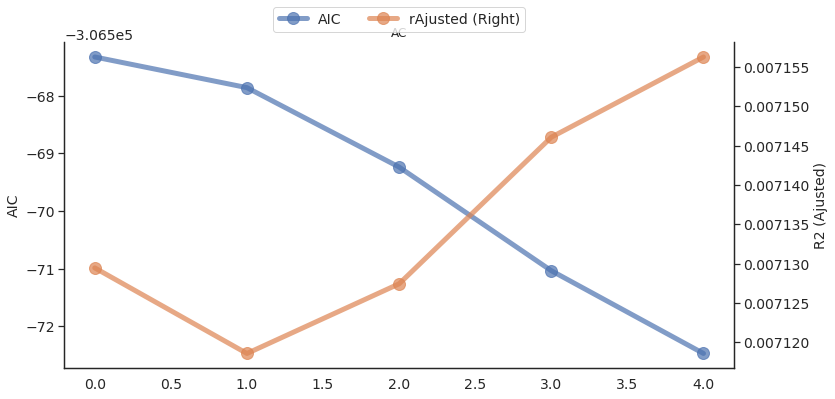

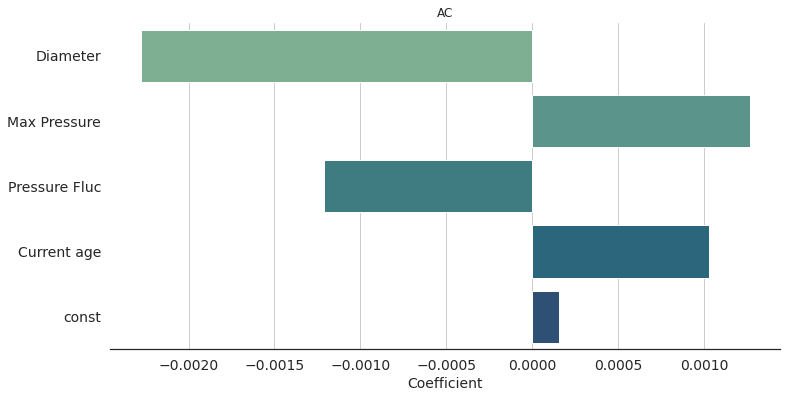

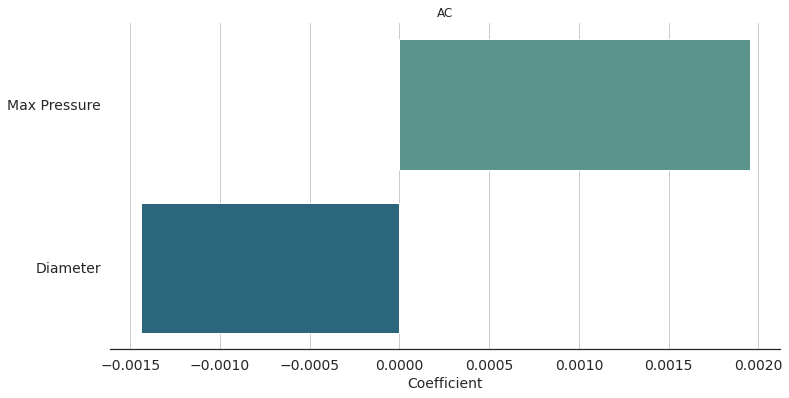

In [241]:
getMLRFowardsLowestP(dfAC.copy(),AC,"PValue")
getMLRFowardsLowestP(dfAC.copy(),AC,"AIC")
getMLRFowardsBest(dfAC.copy(),"AC",SFSModel)
getMLRBackwardsIterMaterial(dfAC.copy(),"AC")
modFinalAC =recursiveFoward(dfAC.copy(),"AC")
#getMLRFowardsBest(dfAC.copy(),"AC",getBestFeature)

Foward PValue  AIC: -211561.85698551056  CN: 14.035437931314465  F: 63.91702250030459  pv: 7.005494372536419e-54
Foward AIC  AIC: -211561.85698551056  CN: 14.035437931314465  F: 63.91702250030459  pv: 7.005494372536419e-54
Best  AIC: -211555.51025160053  CN: 15.908007585073959  F: 36.47003998374244  pv: 3.6538881963504066e-51
Back  AIC: -211561.85698551056  CN: 14.035437931314476  F: 63.91702250030459  pv: 7.005494372536419e-54
RFCV  AIC: -211550.09477813728  CN: 7.2575011971207095  F: 234.66907623758124  pv: 3.241335748515626e-246


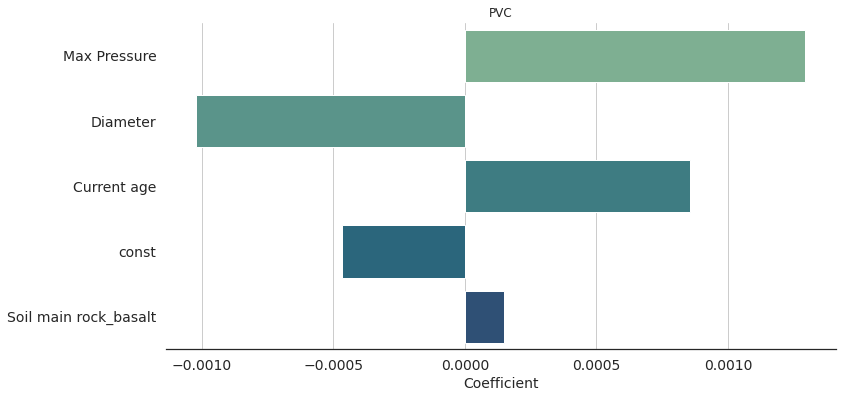

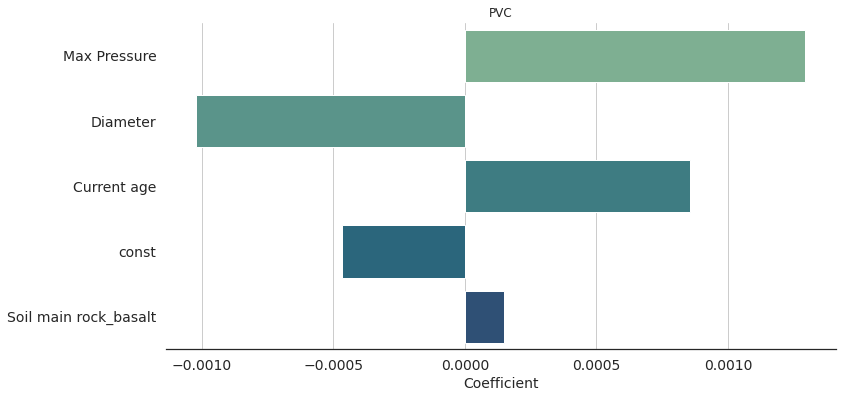

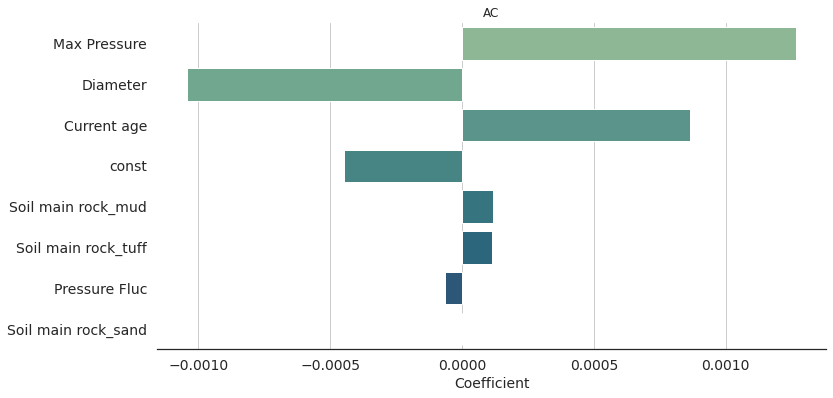

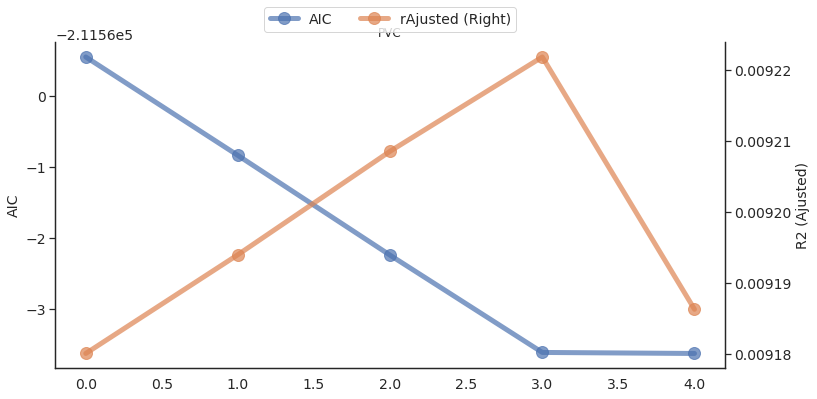

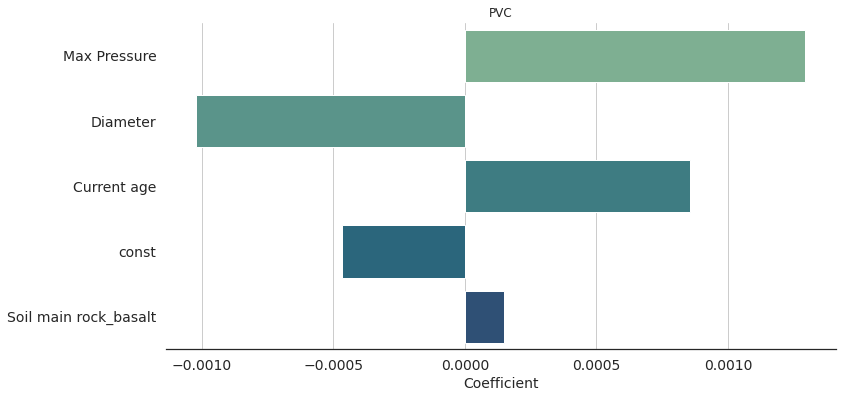

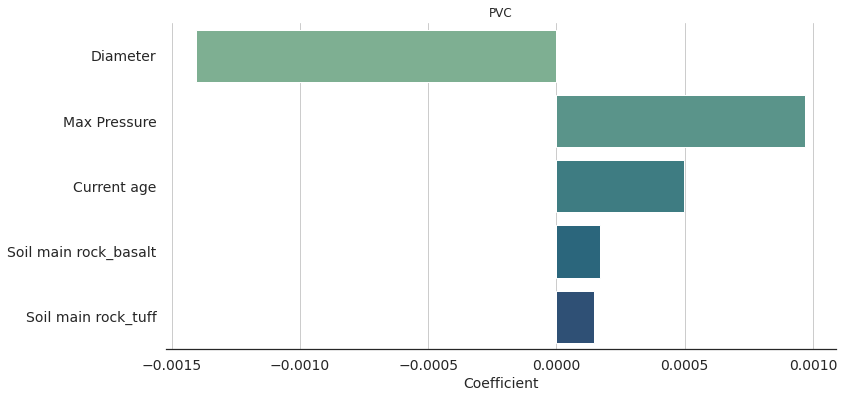

In [242]:
getMLRFowardsLowestP(dfPVC.copy(),PVC,"PValue")
getMLRFowardsLowestP(dfPVC.copy(),PVC,"AIC")
getMLRFowardsBest(dfPVC.copy(),"PVC",SFSModel)
getMLRBackwardsIterMaterial(dfPVC.copy(),"PVC")
modFinalPVC=recursiveFoward(dfPVC.copy(),"PVC")
#getMLRFowardsBest(dfPVC.copy(),"PVC",getBestFeature)

Foward PValue  AIC: -61684.69763639278  CN: 16.657209482869174  F: 30.410637327157456  pv: 1.674536050244523e-36
Foward AIC  AIC: -61684.69763639278  CN: 16.657209482869174  F: 30.410637327157456  pv: 1.674536050244523e-36
Best  AIC: -61672.806962607836  CN: 16.62682546751255  F: 28.407672272257255  pv: 5.583726109373328e-34
Back  AIC: -61684.69763639278  CN: 16.65720948286917  F: 30.410637327157456  pv: 1.674536050244523e-36
RFCV  AIC: -61686.69212201974  CN: 10.215317157876617  F: 109.18165601059907  pv: 2.0329976416921568e-135


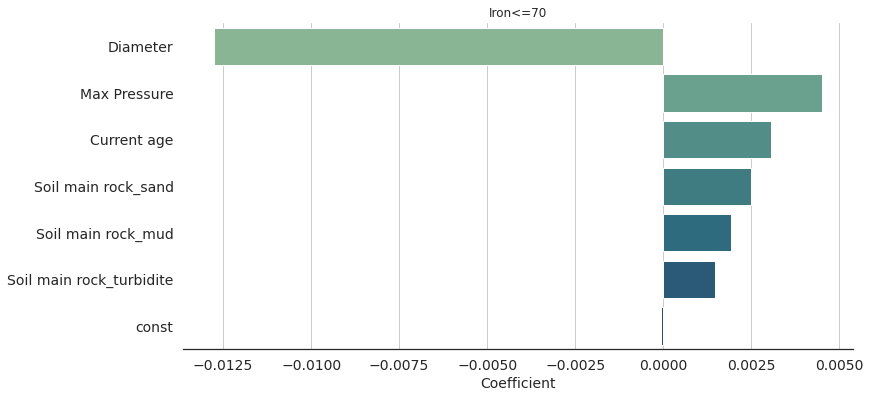

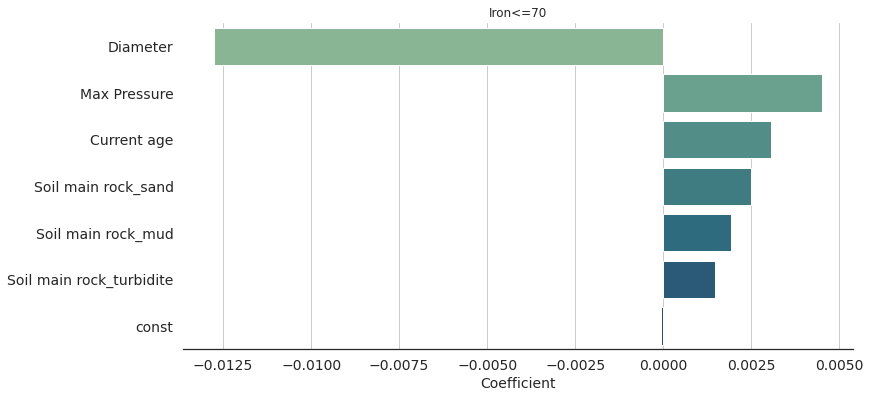

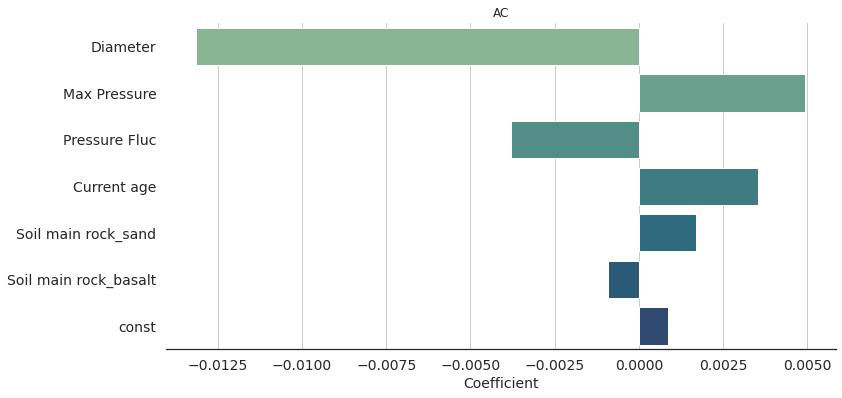

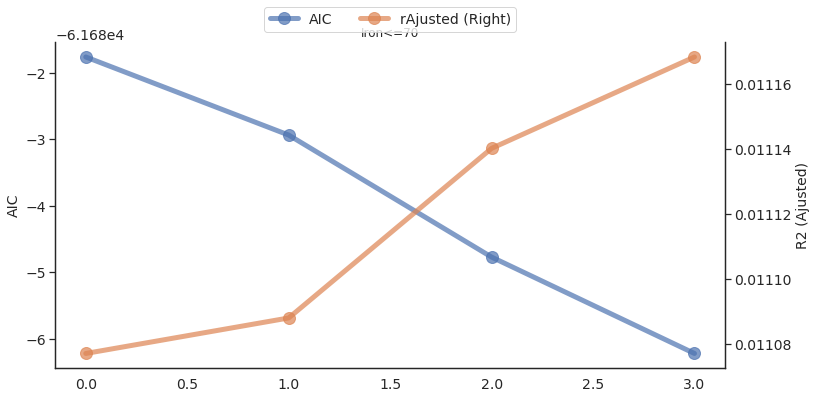

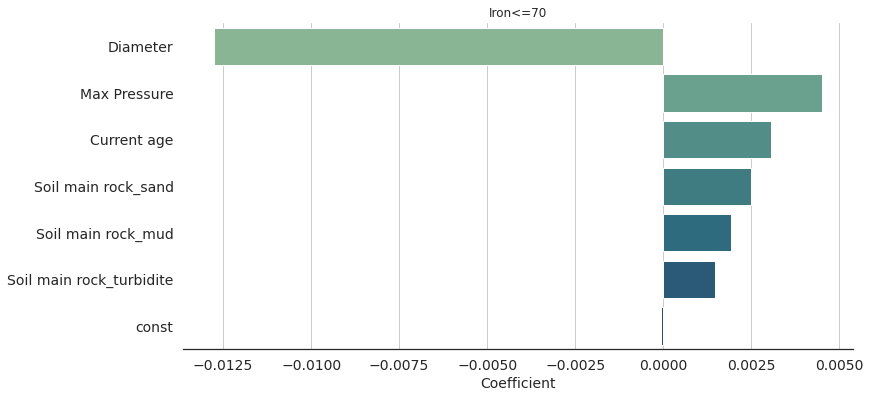

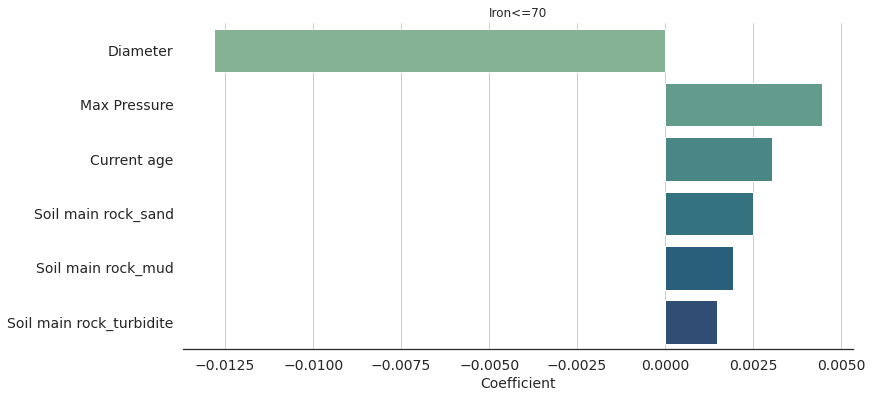

In [243]:
getMLRFowardsLowestP(dfIronLess.copy(),"Iron<=70","PValue")
getMLRFowardsLowestP(dfIronLess.copy(),"Iron<=70","AIC")
getMLRFowardsBest(dfIronLess.copy(),"Iron<=70",SFSModel)
getMLRBackwardsIterMaterial(dfIronLess.copy(),"Iron<=70")
modFinalIronLess=recursiveFoward(dfIronLess.copy(),"Iron<=70")

Foward PValue  AIC: -43186.4386740999  CN: 20.232157235585138  F: 15.486461001828333  pv: 3.1907241838591994e-15
Foward AIC  AIC: -43186.4386740999  CN: 20.232157235585138  F: 15.486461001828333  pv: 3.1907241838591994e-15
Best  AIC: -43186.203508052175  CN: 20.236112482906215  F: 13.200103513461714  pv: 5.783461504287267e-15
Back  AIC: -43184.344495967016  CN: 19.689748713941373  F: 18.33074162364653  pv: 4.939276503600333e-15
RFCV  AIC: -43156.54611508014  CN: 5.668556688199873  F: 199.3117984211988  pv: 4.553729797791616e-86


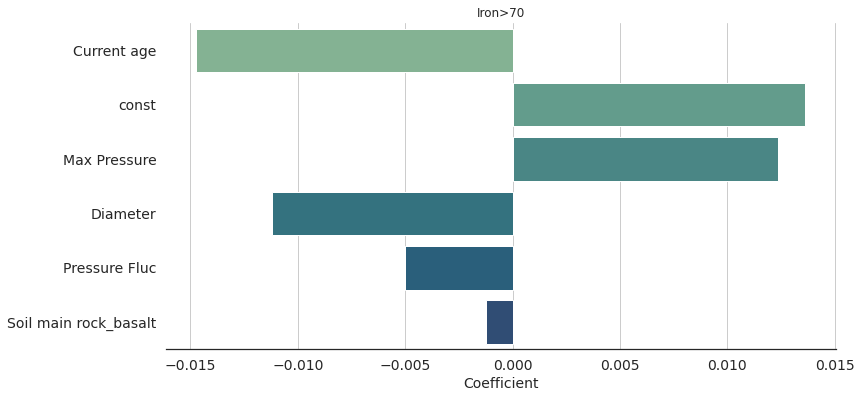

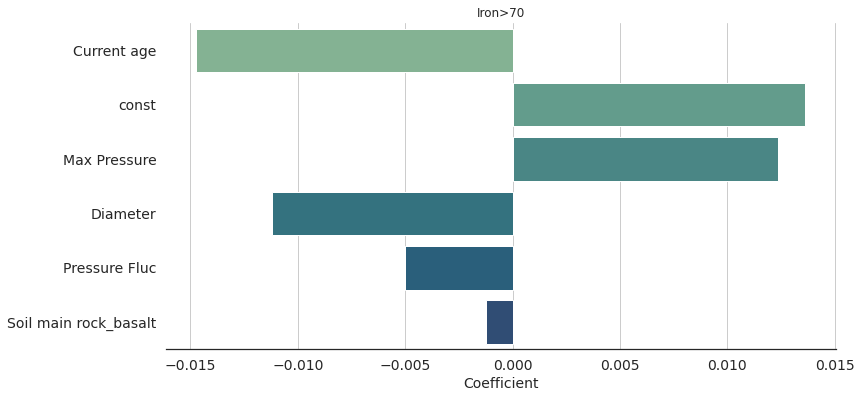

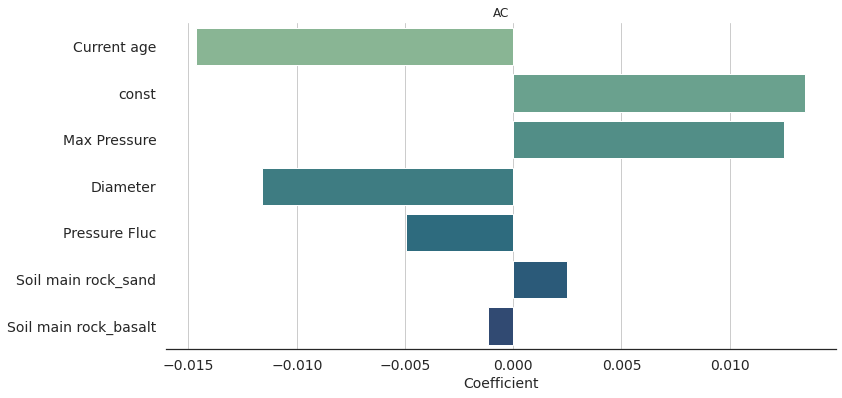

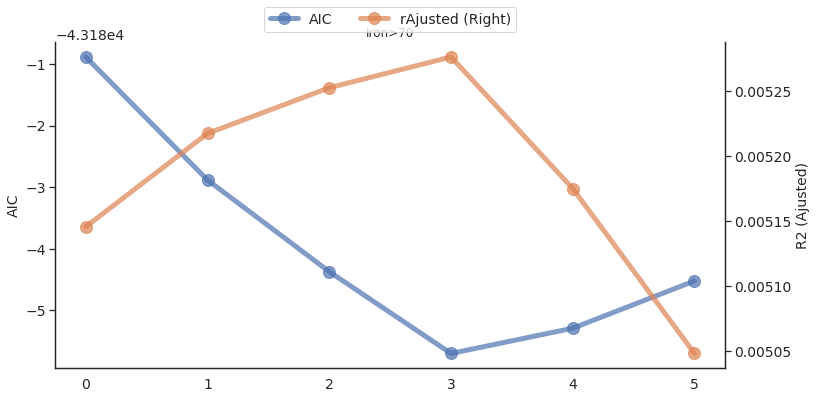

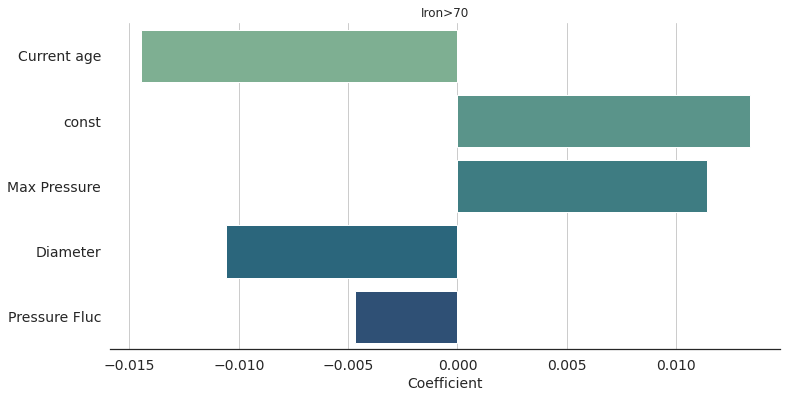

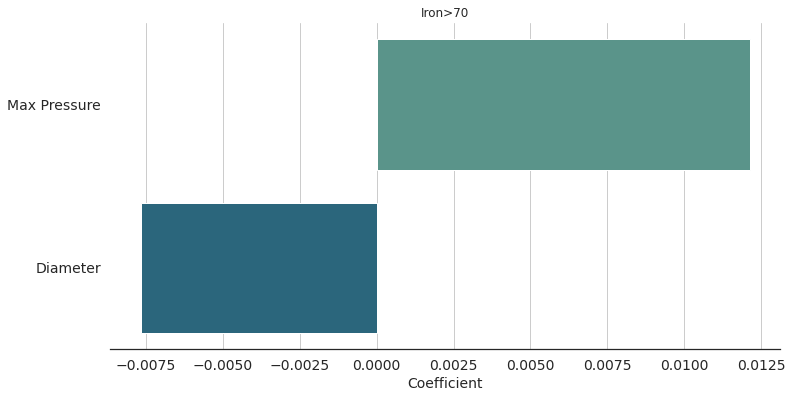

In [244]:
getMLRFowardsLowestP(dfIronMore.copy(),"Iron>70","PValue")
getMLRFowardsLowestP(dfIronMore.copy(),"Iron>70","AIC")
getMLRFowardsBest(dfIronMore.copy(),"Iron>70",SFSModel)
getMLRBackwardsIterMaterial(dfIronMore.copy(),"Iron>70")
modFinalIronM=recursiveFoward(dfIronMore.copy(),"Iron>70")

Foward PValue  AIC: -241194.7163379377  CN: 12.380712368013373  F: 57.39947666246678  pv: 2.4175217427091212e-48
Foward AIC  AIC: -241194.7163379377  CN: 12.380712368013373  F: 57.39947666246678  pv: 2.4175217427091212e-48
Best  AIC: -241197.58960157918  CN: 15.295446500463367  F: 46.89972314108587  pv: 1.7666359561950437e-48
Back  AIC: -241194.7163379377  CN: 12.380712368013358  F: 57.39947666246678  pv: 2.4175217427091212e-48
RFCV  AIC: -241145.16408834985  CN: 5.7398396326695655  F: 177.99405225361866  pv: 1.8789364759722366e-114


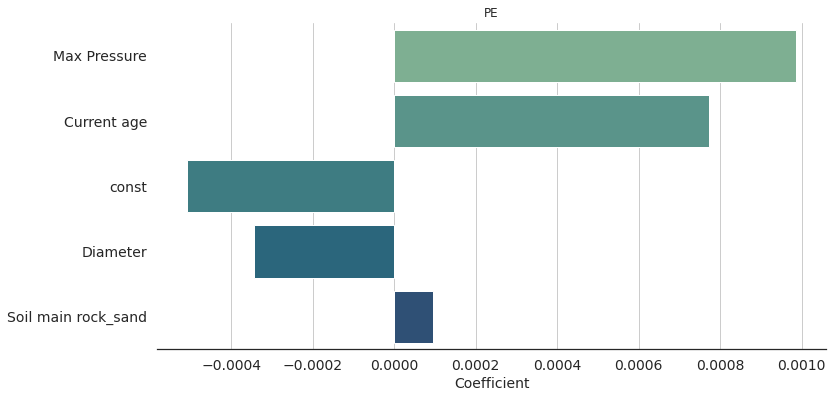

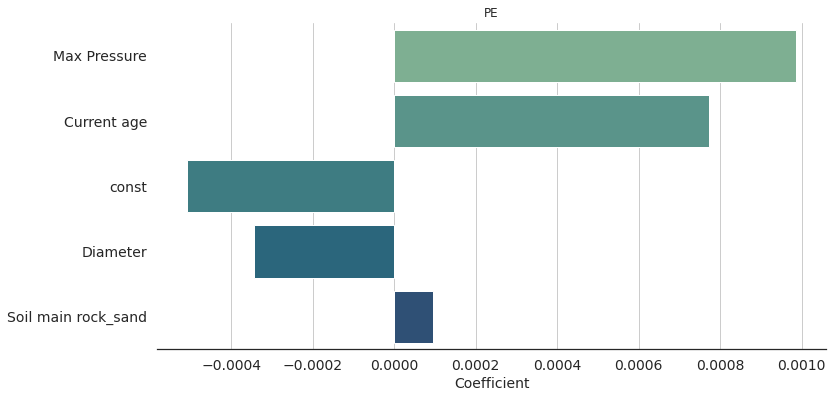

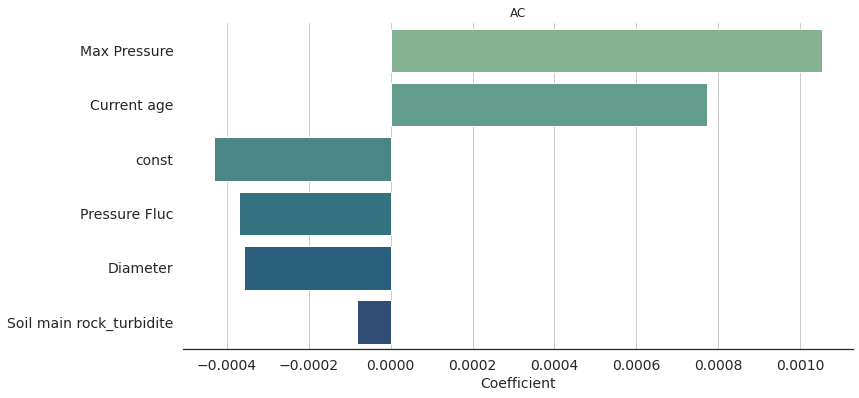

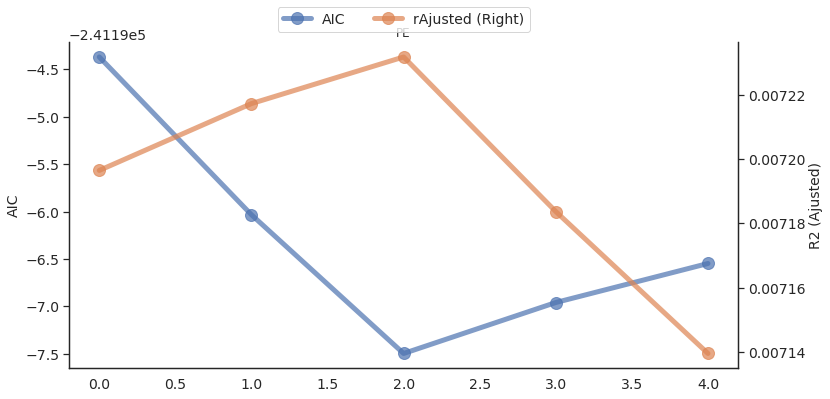

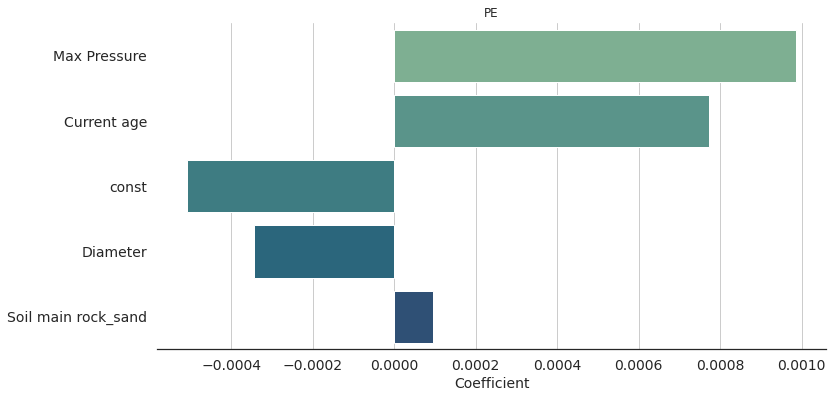

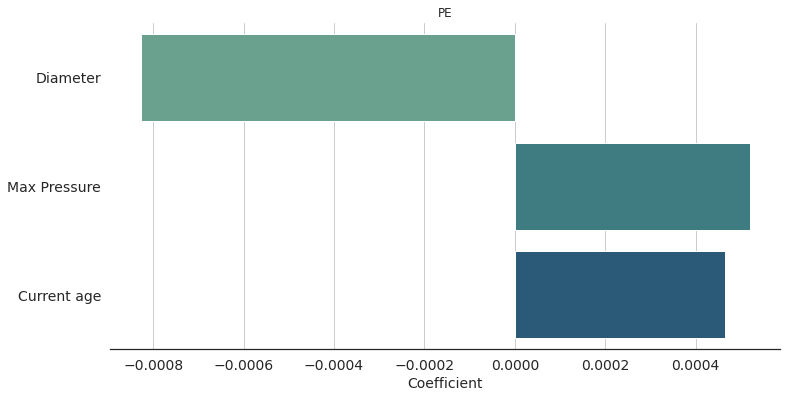

In [245]:
getMLRFowardsLowestP(dfPE.copy(),PE,"PValue")
getMLRFowardsLowestP(dfPE.copy(),PE,"AIC")
getMLRFowardsBest(dfPE.copy(),"PE",SFSModel)
getMLRBackwardsIterMaterial(dfPE.copy(),"PE")
modFinalPE=recursiveFoward(dfPE.copy(),"PE")

# Old --------------------

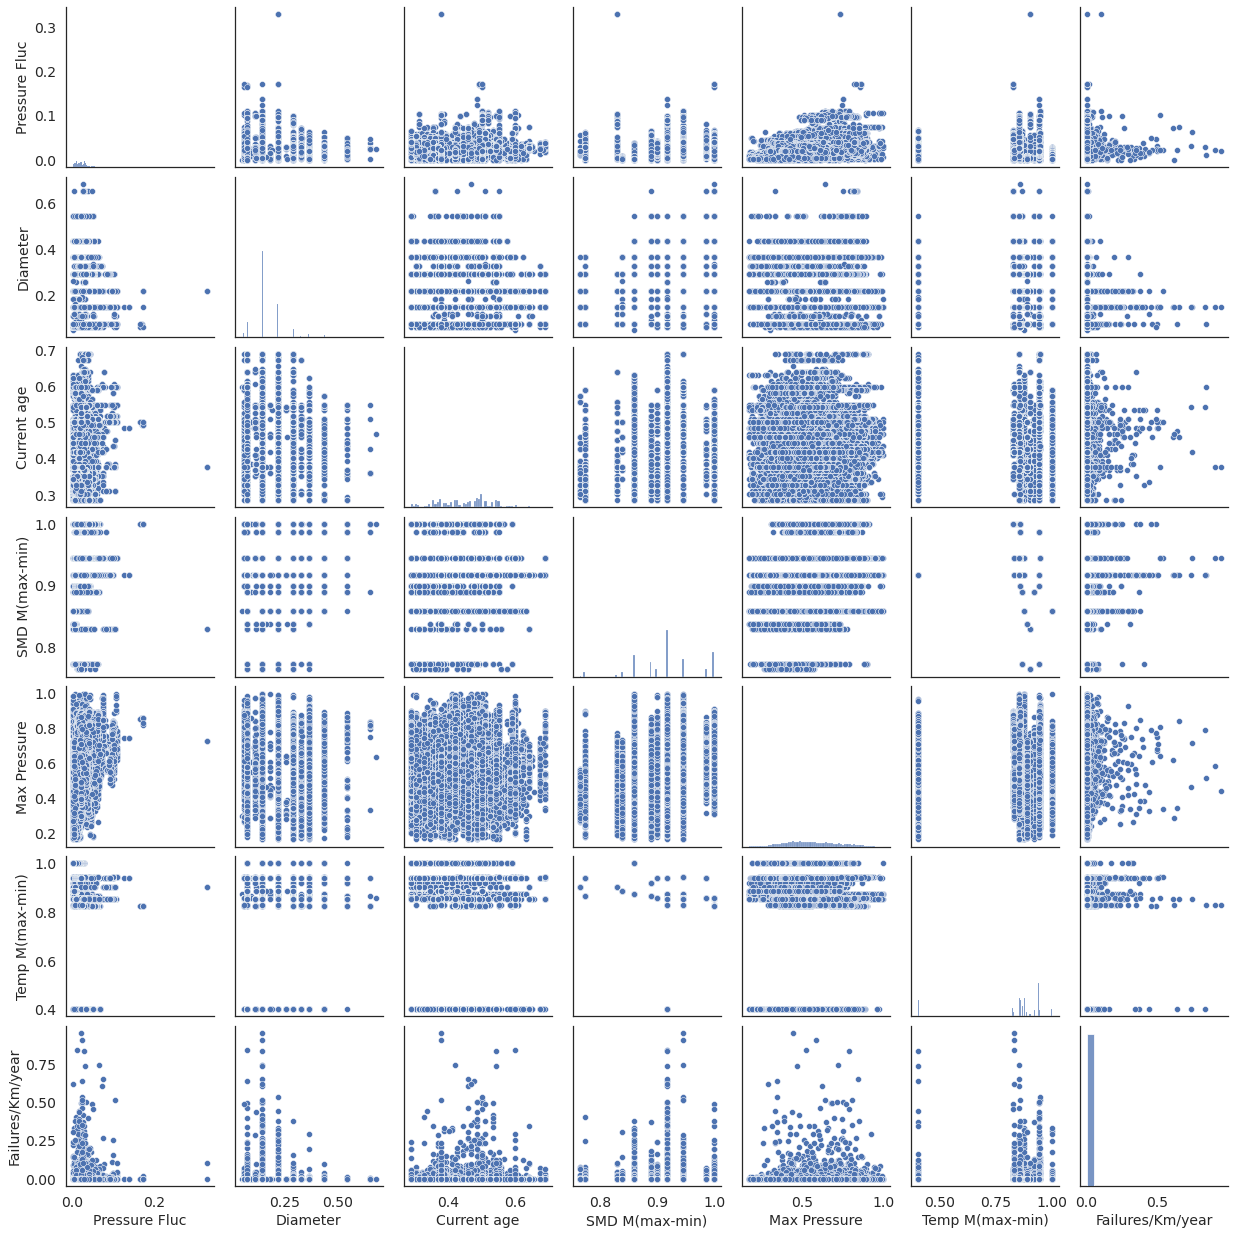

In [24]:
dfACC=dfAC[['Pressure Fluc',DIAMETER,'Current age','SMD M(max-min)','Max Pressure','Temp M(max-min)','Failures/Km/year']]

grid=sns.pairplot(dfACC)


In [18]:
def getMLRFowardsTsta(dfm,material):
    
    y= dfm[['Failures/Km/year']].copy()
    w= dfm[['Shape_Leng']].copy() 
    Xall= dfm.iloc[:, 2:]
    results = []
    
    X = Xall.iloc[:,1:2]
    X = sm.add_constant(X)[['const']]
    
    while Xall.shape[1]>0:
        
        #For each variable looks the better fit
        Tsta=[]
        for v in Xall.columns.tolist():
            
            Xtest = X.join(Xall[[v]]).copy()
            mTest = sm.WLS(y, Xtest,weights=w).fit()
            resultP= [v,mTest.pvalues[v]]
            Tsta.append(resultP)
        
        #gets the best feature by min Tstatistic pvalue
        fDF= pd.DataFrame(Tsta, columns =['v','Tsta'])
        bestF= fDF.loc[fDF['Tsta'].idxmin()]['v']
        #print("Best:",bestF)
        
        #if fDF['Tsta'].min() > SIG:
          #  break
        
        #runs the model and check the p-values
        bestFdf= Xall.pop(bestF) #remove it from the dataset
        X = X.join(bestFdf).copy()
        modelTestP = sm.WLS(y, X,weights=w).fit()
        pvaluesTest= modelTestP.pvalues[1:]
        invalidPval= any([pv > SIG for pv in pvaluesTest])
        
        while invalidPval:
            print("Invalid p values with ", bestF)
            maxV= pvaluesTest.idxmax()
            print("Max:", maxV)
            X.pop(maxV)
            print("Then X has now the features ",X.columns.tolist())
            modelTestP = sm.WLS(y, X,weights=w).fit()
            pvaluesTest= modelTestP.pvalues[1:]
            invalidPval= any([pv > SIG for pv in pvaluesTest])
            
        
        model = sm.WLS(y, X,weights=w).fit()
        results.append([bestF,model.aic,model.rsquared_adj])
        
        
    resultDf= pd.DataFrame(results, columns =['Variable added','AIC','rAjusted'])
    resultDf.set_index('Variable added',inplace=True)
    
    getModelIterGraph(resultDf,10,material,"FowPval")
    getGraphCoef(model,material,"FowPval")
    print("FowardTsta ","AIC:",model.aic," CN:",model.condition_number," F:",model.fvalue, " pv:", model.f_pvalue)

def getMLRFowardsAIC(dfm,material):
    
    y= dfm[['Failures/Km/year']].copy()
    w= dfm[['Shape_Leng']].copy() 
    Xall= dfm.iloc[:, 2:]
    results = []
    
    X = Xall.iloc[:,1:2]
    X = sm.add_constant(X)[['const']]
    
    while Xall.shape[1]>0:
        
        #For each variable looks the better fit
        AIC=[]
        for v in Xall.columns.tolist():
            
            Xtest = X.join(Xall[[v]]).copy()
            mTest = sm.WLS(y, Xtest,weights=w).fit()
            AIC.append([v,mTest.aic])
        
        #gets the best feature by min AIC
        aicDF= pd.DataFrame(AIC, columns =['v','aic'])
        bestF= aicDF.loc[aicDF['aic'].idxmin()]['v']
        
        #runs the model and check the p-values
        bestFdf= Xall.pop(bestF) #remove it from the dataset
        XtestP = X.join(bestFdf).copy()
        #print("X has the features ",X.columns.tolist())
        modelTestP = sm.WLS(y, XtestP,weights=w).fit()
        invalidPval= any([pv > SIG for pv in modelTestP.pvalues[1:]])
        
        if not invalidPval:
            X = X.join(bestFdf).copy()
            model = sm.WLS(y, XtestP,weights=w).fit()
            results.append([bestF,model.aic,model.rsquared_adj])
        #else:
            #print("Invalid p values with ", bestF)
        
        
    resultDf= pd.DataFrame(results, columns =['Variable added','AIC','rAjusted'])
    resultDf.set_index('Variable added',inplace=True)
    
    getModelIterGraph(resultDf,10,material,"AIC")
    getGraphCoef(model,material,"AIC")
    print("FowAIC ","AIC:",model.aic," CN:",model.condition_number," F:",model.fvalue, " pv:", model.f_pvalue)
    

In [22]:
def getRegressionByMaterial(df,sca= None,label="without"):
    
    columnsMaterials = ['MATERIAL_'+ m for m in MATERIALS_PREDOMI]
    regres = []
    models = []
    scalers = []
    scalers_y= []
    
    for m in zip(columnsMaterials):
        
        #get only the values of that material
        dfm= df[df[m]==1].copy()
        #drops the dummies for each material
        dfm=dfm.drop(columns= columnsMaterials)
        
        #get score for each variable
        varScores= selectFeaturesUnivariate(dfm.copy())
        print("Material: ",m)
        display(varScores) 
        
        #var 
        y= dfm[['Failures/Km/year']].copy()
        w= dfm[['Shape_Leng']].copy() 
        X= dfm.iloc[:, 2:]
        
        #scalling
        if sca is not None:
            scaler = sca.fit(X)
            X_scaled= scaler.transform(X)
            X_scaleddf= pd.DataFrame(data=X_scaled, columns=X.columns.tolist())
            scaler_y = sca.fit(y)
            y_scaled= scaler_y.transform(y)
            y_scaleddf= pd.DataFrame(data=y_scaled, columns=y.columns.tolist())
            scalers.append(scaler)
            scalers_y.append(scaler_y)
        else:
            X_scaleddf= X.copy()
            y_scaleddf= y.copy()

        
        #display(X_scaleddf.describe())
        #display(y_scaleddf.describe())
        
        X_scaleddf = sm.add_constant(X_scaleddf)
        
        model = sm.WLS(y_scaleddf, X_scaleddf,weights=w).fit()
        
        #each var in the model
        for v in X.columns.tolist():
            
            regres.append([m,v,model.params[v], model.bse[v], model.pvalues[v]])
            
        print("rAjusted= ", model.rsquared_adj,"AIC= ", model.aic, "BIC= ", model.bic )
        
        models.append(model)
        
    
    dfResult=pd.DataFrame(regres, columns =[MATERIAL,'Variable', 'Slope','Std dev', 'Slope P-value'])
    
    dfResult.to_csv('Output/Regressions/'+"FailureRateAllVarRegPerMaterial"+ label +'.csv') 
    
    return models, scalers, scalers_y


In [25]:
def getLocationClusters(df):

    columnsMaterials = ['MATERIAL_'+ m for m in MATERIALS_PREDOMI] 
    dfs = []

    for m in columnsMaterials:

        dfm= df[df[m]==1].copy()

        #var 
        X= dfm[['LAT','LONG','Failures/Km/year']].copy()
        
        col_sc=X[['Failures/Km/year']].copy()
        
        X_scaled = RobustScaler().fit(col_sc).transform(col_sc)
        X_scaleddf= pd.DataFrame(data=X_scaled, columns=['Failures/Km/year'])
        
        X['Failures/Km/year']= X_scaleddf['Failures/Km/year'].values
       
        model = MeanShift()
        # fit the model
        model.fit(X)
        # assign a cluster to each example
        dfm['Cluster'] = model.predict(X)
        dfM = pd.get_dummies(dfm)
        
        dfs.append(dfM)
             
    return dfs

dfsList= getLocationClusters(dfFinal.copy())  

In [23]:
def getRegressionByMaterialList(dfs,sca= None,label="without"):
    
    columnsMaterials = ['MATERIAL_'+ m for m in MATERIALS_PREDOMI]
    regres = []
    models = []
    scalers = []
    scalers_y= []
    
    for dfm,m in zip(dfs,MATERIALS_PREDOMI):
        
        dfm.drop(columns=["LAT","LONG"],inplace=True)
        dfm=dfm.drop(columns= columnsMaterials)
        
        #get score for each variable
        varScores= selectFeaturesUnivariate(dfm.copy())
        print("Material: ",m)
        display(varScores) 
        
        #var 
        y= dfm[['Failures/Km/year']].copy()
        w= dfm[['Shape_Leng']].copy() 
        X= dfm.iloc[:, 2:]
        
        #scalling
        if sca is not None:
            scaler = sca.fit(X)
            X_scaled= scaler.transform(X)
            X_scaleddf= pd.DataFrame(data=X_scaled, columns=X.columns.tolist())
            scaler_y = sca.fit(y)
            y_scaled= scaler_y.transform(y)
            y_scaleddf= pd.DataFrame(data=y_scaled, columns=y.columns.tolist())
            scalers.append(scaler)
            scalers_y.append(scaler_y)
        else:
            X_scaleddf= X.copy()
            y_scaleddf= y.copy()

        
        #display(X_scaleddf.describe())
        #display(y_scaleddf.describe())
        
        X_scaleddf = sm.add_constant(X_scaleddf)
        
        model = sm.WLS(y_scaleddf, X_scaleddf,weights=w).fit()
        
        #each var in the model
        for v in X.columns.tolist():
            
            regres.append([m,v,model.params[v], model.bse[v], model.pvalues[v]])
            
        print("rAjusted= ", model.rsquared_adj,"AIC= ", model.aic, "BIC= ", model.bic )
        
        models.append(model)
        
    
    dfResult= pd.DataFrame(regres, columns =[MATERIAL,'Variable', 'Slope','Std dev', 'Slope P-value'])
    
    dfResult.to_csv('Output/Regressions/'+"FailureRateAllVarRegPerMaterial"+ label +'.csv') 
    
    return models, scalers, scalers_y



In [26]:
#regressions for each material with different types of scaling
mods, scax, scay = getRegressionByMaterialList(dfsList.copy(),MaxAbsScaler(),"maxabs")

Material:  AC


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


,Feature,Score
20,main_rock_tuff,7.084169
8,SMD M(max-min),3.376776
0,NOM_DIA_MM,1.801923
7,Rain M(max-min),1.547702
21,main_rock_turbidite,1.155074
10,Press_fluc,0.742064
1,Age Today,0.578878
18,main_rock_sand,0.256635
9,MOD_MAXPRE,0.243416
24,Cluster,0.226085


rAjusted=  0.0061529102781405776 AIC=  -546940.2431880195 BIC=  -546766.8920065908
Material:  PVC


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


,Feature,Score
9,MOD_MAXPRE,24.539145
8,SMD M(max-min),13.299948
10,Press_fluc,13.205080
20,main_rock_tuff,8.776741
0,NOM_DIA_MM,8.357435
18,main_rock_sand,6.431131
11,main_rock_basalt,3.613678
6,Temp M(max-min),2.943445
1,Age Today,2.269935
24,Cluster,1.777066


rAjusted=  0.006816589351198332 AIC=  -257263.14781616302 BIC=  -257098.5842891507
Material:  Iron


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


,Feature,Score
14,main_rock_fill,8.908622
9,MOD_MAXPRE,8.900224
7,Rain M(max-min),7.723553
0,NOM_DIA_MM,4.499168
10,Press_fluc,1.847782
8,SMD M(max-min),1.671465
21,main_rock_turbidite,1.158940
6,Temp M(max-min),0.625216
1,Age Today,0.501336
16,main_rock_mud,0.406678


rAjusted=  0.002381351721118641 AIC=  -301616.7757195821 BIC=  -301483.87092316564
Material:  PE


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


,Feature,Score
9,MOD_MAXPRE,9.963010
11,main_rock_basalt,8.656391
1,Age Today,7.404620
8,SMD M(max-min),4.365064
0,NOM_DIA_MM,3.942996
10,Press_fluc,2.070930
18,main_rock_sand,2.062659
24,Cluster,1.634868
21,main_rock_turbidite,1.497588
7,Rain M(max-min),1.384775


rAjusted=  0.005030056453749987 AIC=  -337794.0231622951 BIC=  -337626.2100517361


In [38]:
#too variable -----------------------------
def selectFeaturesRecursive(df):
    
    y= df['Failures/Km/year'].copy()
    X= df.iloc[:, 2:]
    
    print("Entro ", dt.now())
    
    scaler = RobustScaler().fit(X)

    X_scaled=scaler.transform(X)
    estimator = LinearSVR()

    selector = RFECV(estimator)
    selector = selector.fit(X_scaled, y)
    print("Salio",dt.now())
    dfscores=pd.DataFrame(selector.ranking_)
    dfcol=pd.DataFrame(X.columns)

    f=pd.concat([dfcol,dfscores],axis=1)
    f.columns=['Feature','Score']
    
    return f.sort_values(by='Score',ascending=False)
    

col7=selectFeaturesRecursive(dfFinal.copy())

Entro  2022-02-07 19:16:01.205186
Salio 2022-02-07 19:17:57.689816


In [ ]:
# to put in the location section ----------------------------------------------------------------------

<AxesSubplot:xlabel='LAT', ylabel='LONG'>

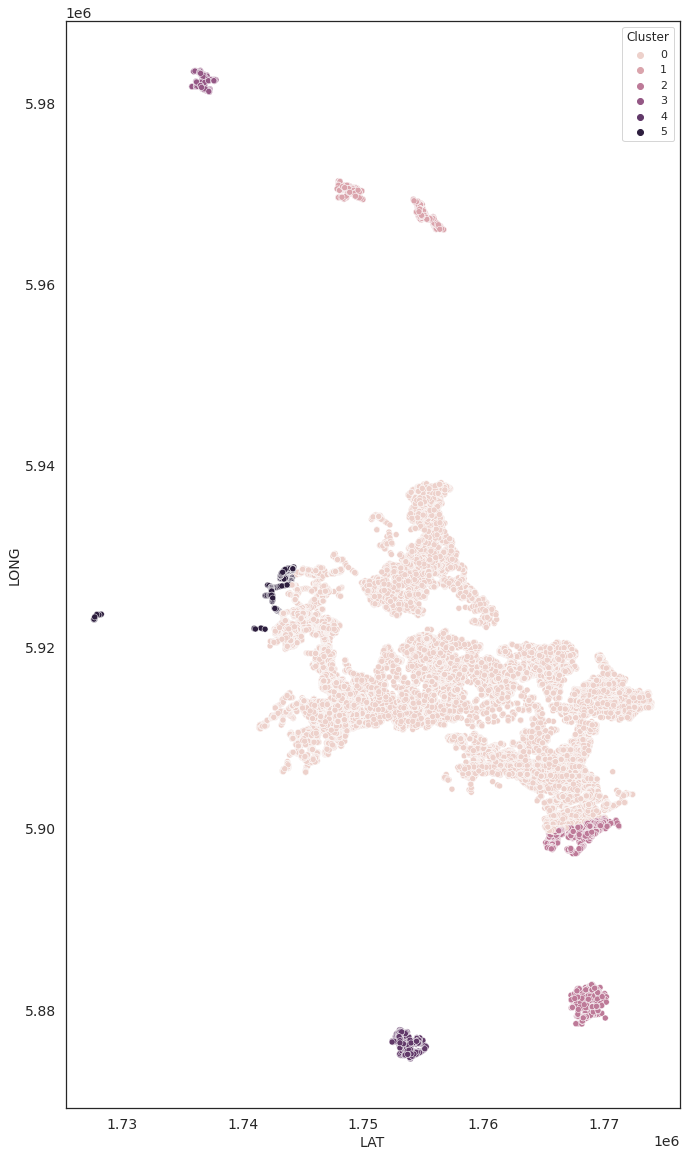

In [14]:
def getClusterMaps(dfs):

    for m in zip([0,1,2,3],MATERIALS_PREDOMI):

        fig, ax = plt.subplots(figsize=(11,20))

        sns.scatterplot(data=dfs[m], x="LAT", y="LONG", hue="Cluster",ax=ax)

        fig.savefig('Maps_Graph/CoordinatesAnalysis/'+ 'Clusters'+ma + '.png', dpi=200,bbox_inches='tight')



In [ ]:
# was to test but did not finish (i worked pout in excel )

RFCV  AIC: -258985.36461930798  CN: 9.279230958522101  F: 1088.4211352739817  pv: 0.0


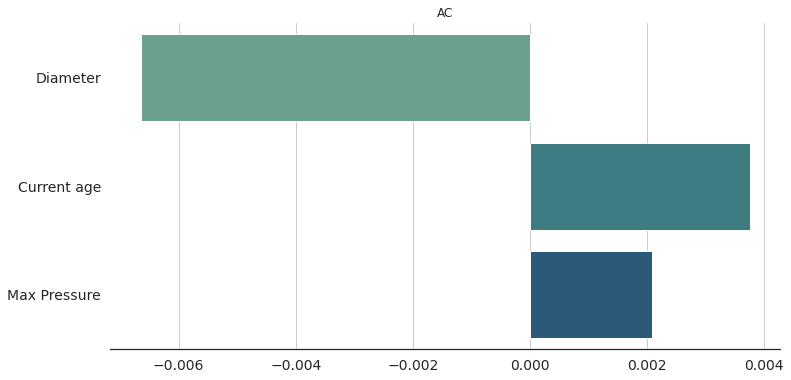

In [22]:
mod=recursiveFoward(dfAC.copy(),"AC")


In [87]:
a=joinWithLocation(predoMaterials.copy())

/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
After cleaning suburbs  198694


In [88]:
predoMaterials.shape[0]

198694

In [91]:
len(a[SUBURB].unique())

215

In [93]:
a[SUBURB].unique().tolist()

['HENDERSON',
 'FORREST HILL',
 'OTAHUHU',
 'TORBAY',
 'BIRKENHEAD',
 'TAKAPUNA',
 'HAURAKI',
 'PT CHEVALIER',
 'ROSEDALE',
 'CASTOR BAY',
 'TOTARA VALE',
 'SUNNYNOOK',
 'BLOCKHOUSE BAY',
 'NEW WINDSOR',
 'WATERVIEW',
 'AVONDALE',
 'ELLERSLIE',
 'CAMPBELLS BAY',
 'WAIRAU VALLEY',
 'PENROSE',
 'GLEN INNES',
 'MT WELLINGTON',
 'WAI-O-TAIKI BAY',
 'ST JOHNS',
 'PT ENGLAND',
 'BEACH HAVEN',
 'BIRKDALE',
 'CHATSWOOD',
 'NORTHCOTE',
 'BROWNS BAY',
 'WINDSOR PARK',
 'MAIRANGI BAY',
 'MURRAYS BAY',
 'STONEFIELDS',
 'WAIAKE',
 'ROTHESAY BAY',
 'GLENFIELD',
 'GREENHITHE',
 'NARROW NECK',
 'MILFORD',
 'PINEHILL',
 'NORTHCROSS',
 'HILLCREST',
 'NORTHCOTE POINT',
 'ALBANY',
 'PANMURE',
 'ST HELIERS',
 'GLENDOWIE',
 'MT ALBERT',
 'KOHIMARAMA',
 'BAYVIEW',
 'BELMONT',
 'MISSION BAY',
 'MEADOWBANK',
 'WESTERN SPRINGS',
 'ST LUKES',
 'OWAIRAKA',
 'MT ROSKILL',
 'HILLSBOROUGH',
 'LYNFIELD',
 'EPSOM',
 'ROYAL OAK',
 'THREE KINGS',
 'AUCKLAND CENTRAL',
 'WAIKOWHAI',
 'SANDRINGHAM',
 'WESTMERE',
 'WEST HAR